In [2]:
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import numpy as np
import mdtraj as md
import pickle
import glob
import sys
import os
sys.path.append('/home/xgu/Tiwary/S100/rave/scripts')
import S100CVs as scv
# from openmm_utils import *
os.system('pwd')
import networkx as nx

/home/xgu/Tiwary/S100_clean


In [20]:
def spib_color(spib_labels):
    cmap = matplotlib.colormaps["tab20"]
    c_array=np.where(np.reshape(spib_labels,(spib_labels.shape[0]*spib_labels.shape[1],spib_labels.shape[2]))==1)[1]
    sets=list(set(c_array))
    color_dict={}
    for i in range(len(sets)):
        color_dict[sets[i]]=i
    color_array=[color_dict[col] for col in c_array];
    return color_array

In [21]:
import matplotlib.animation as animation
from PIL import Image  # Pillow library for working with images

# Function to update the frame in the animation
def update(frame):
    img = Image.open(png_files[frame])
    ax.imshow(img)
    # set axis spines (the box around the plot) to be invisible
    plt.setp(ax.spines.values(), alpha = 0)
    # set both tick marks and tick labels to size 0
    ax.tick_params(which = 'both', size = 0, labelsize = 0)
    dt = f"{int(5*(frame+1))} ns"
    ax.set_title(f'dt = {dt}')

**std_filter for global features**

In [4]:
cvs=[] 
discard = ['S100A1_257_ca', 'S100B_105_ca', 'S100B_164_ca', 'S100B_166_ca']
for prot in ['S100B','S100A1']:
    cv_files = glob.glob(f"/home/xgu/Tiwary/S100_clean/unbiasedMD/{prot}_*_ca/Dist*.txt")
    for file in cv_files:
        if file.split('/')[-2] in discard:
            print('Skipping: ', file.split('/')[-2])
            continue
        cvs.append(np.loadtxt(file))
cvs = np.concatenate(cvs)
stds=np.std(cvs, axis=0)
std_max = np.max(stds)
op_id=[]
for i in range(len(stds)):
    if stds[i] >= 0.25*std_max:
        op_id.append(i)
print(op_id, len(op_id))
np.savetxt(f'G_spib_op_id.txt', op_id, fmt='%d')

Skipping:  S100B_105_ca
Skipping:  S100B_105_ca
Skipping:  S100B_164_ca
Skipping:  S100B_164_ca
Skipping:  S100B_166_ca
Skipping:  S100B_166_ca
Skipping:  S100A1_257_ca
Skipping:  S100A1_257_ca
[1, 2, 3, 4, 6, 9, 10, 14, 15, 17, 18, 19, 24, 26] 14


In [6]:
ends = [int(i) for i in np.loadtxt('/home/xgu/Tiwary/S100_clean/ends.index')]
res_pairs = []
for i in range(len(ends)):
    for j in range(i+1, len(ends)):
        res_pairs.append([ends[i], ends[j]])
res_pairs = np.asarray(res_pairs)
# res_pairs[np.argsort(stds)[:14]]
res_pairs[op_id]

array([[ 1, 29],
       [ 1, 39],
       [ 1, 51],
       [ 1, 60],
       [ 1, 82],
       [17, 51],
       [17, 60],
       [29, 51],
       [29, 60],
       [29, 82],
       [39, 51],
       [39, 60],
       [51, 82],
       [60, 82]])

**SPIB states**

In [3]:
wkdir = "/home/xgu/Tiwary/S100_clean/spib_G_tica/"
os.chdir(wkdir)
# hyper = 'b=0.0500_learn=0.000100_'
# lags = np.arange(500, 8100, 500)
hyper = 'b=0.0100_learn=0.001000_'
lags = np.arange(500, 5100, 500)

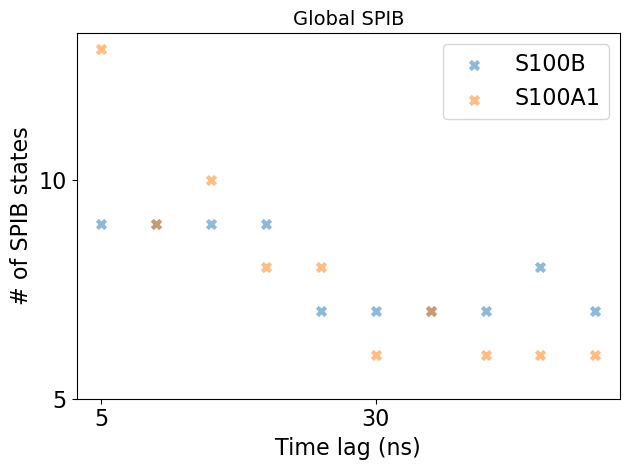

In [5]:
for prot in ['S100B','S100A1']:
    listindices = glob.glob(f'{prot}/{prot}_input/colvar*')
    nstates=[]
    for lag in lags:
        prefix=f"{prot}/dt-{lag}/SPIB/Unweighted_d=2_t={lag}_{hyper}"
        spib_labels=[np.load(prefix+"traj%i_labels0.npy"%i) for i in range(len(listindices))]
        spib_labels = np.concatenate(spib_labels)
        c_array=np.where(spib_labels==1)[1]
        nstate = len(set(c_array))
        nstates.append(nstate)
    plt.scatter(lags*1e-2, nstates, marker='x', linewidth=3, label=f'{prot}',alpha=0.5)

plt.xlabel('Time lag (ns)', fontsize=16)
plt.ylabel('# of SPIB states', fontsize=16)
plt.xticks(np.arange(5,51,25), fontsize=16)
plt.yticks([5,10], fontsize=16)
plt.legend(fontsize=16)
plt.title("Global SPIB", fontsize=14)
plt.tight_layout()
plt.savefig(f"SPIB_1_states.png",dpi=300)

**SPIB dt/latent-space selection**

In [6]:
for prot in ['S100B','S100A1']:
    op_max = np.load(f"{prot}/{prot}_input/max_unb.npy")
    op_min = np.load(f"{prot}/{prot}_input/min_unb.npy")
    ls = []
    listindices = glob.glob(f"{prot}/{prot}_input/CV*")
    for i in range(len(listindices)):
        ls.append((np.loadtxt(f"{prot}/{prot}_input/CVs_{i}.txt")-op_min)/(op_max-op_min))

    ls_array=np.array(ls)
    ls_array=np.reshape(ls_array,(ls_array.shape[0]*ls_array.shape[1],ls_array.shape[2]))

    input_index=[np.ones(ls[i].shape[0],dtype=int)+i for i in range(len(listindices))]
    input_index=np.array(input_index)
    input_color=np.reshape(input_index,(input_index.shape[0]*input_index.shape[1]))
    for lag in lags:
        dt = f"{lag*1e-2} ns"
        prefix=f"{prot}/dt-{lag}/SPIB/Unweighted_d=2_t={lag}_{hyper}"
        weights=np.load(prefix+"z_mean_encoder_weight0.npy")

        md_array = np.dot(ls_array, weights.T)

        spib_labels=[np.load(prefix+"traj%i_labels0.npy"%i) for i in range(len(listindices))]
        spib_labels=np.array(spib_labels)
        color_array=spib_color(spib_labels)


        fig = plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plot=plt.scatter(md_array.T[0],md_array.T[1],c=input_color,s=1,alpha=0.5,cmap="tab20")
        plt.title('Unbiased MD input traj in L space',y=1.0)
        plt.xlabel("$\sigma_1^G$",fontsize=15)
        plt.ylabel("$\sigma_2^G$",fontsize=15)
        plt.ylim([min(md_array.T[1])-0.2,max(md_array.T[1])+0.2])
        plt.xlim([min(md_array.T[0])-0.1,max(md_array.T[0])+0.1])
        cbar = plt.colorbar(plot)
        cbar.set_ticks([])

        plt.subplot(1,2,2)
        plot=plt.scatter(md_array.T[0],md_array.T[1],s=1,alpha=0.5,c=color_array,cmap="tab20")
        plt.title('Unbiased MD SPIB states in L space',y=1.0)
        plt.xlabel("$\sigma_1^G$",fontsize=15)
        plt.ylabel("$\sigma_2^G$",fontsize=15)
        plt.ylim([min(md_array.T[1])-0.2,max(md_array.T[1])+0.2])
        plt.xlim([min(md_array.T[0])-0.1,max(md_array.T[0])+0.1])
        plt.colorbar(plot)


        plt.subplots_adjust(hspace=0.3, wspace=0.2)
        plt.tight_layout()
        plt.savefig(f"G_lspace_{prot}_{lag}.png",dpi=300)
        plt.close()

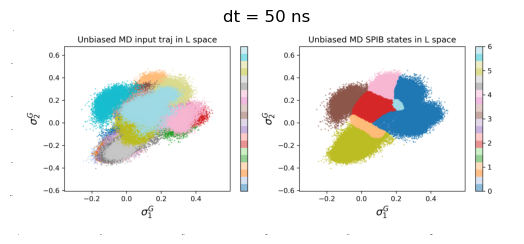

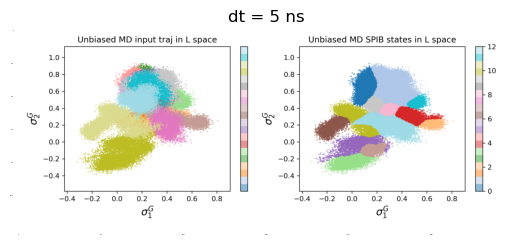

In [7]:
for prot in ['S100B','S100A1']:
    png_files=[]
    for lag in lags:
        png_files.append(f"G_lspace_{prot}_{lag}.png")

    fig, ax = plt.subplots()
    # Create and save the animation
    ani = animation.FuncAnimation(fig, update, frames=len(png_files), interval=200)
    ani.save(f'G_lspace_{prot}.mp4', writer='ffmpeg', fps=2, dpi=300)

*Time lag of 25 ns is selected for G_SPIB*

In [8]:
lag = 2500
dt = f"{lag*1e-2} ns"
# generate input for WHAM metafile
for prot in ['S100B','S100A1']:
    os.chdir(f'{wkdir}')
    op_max = np.load(f"{prot}/{prot}_input/max_unb.npy")
    op_min = np.load(f"{prot}/{prot}_input/min_unb.npy")
    prefix=f"{prot}/dt-{lag}/SPIB/Unweighted_d=2_t={lag}_{hyper}"
    wts=np.load(prefix+"z_mean_encoder_weight0.npy")
    
    if not os.path.isdir(f'IB_{prot}_{lag}'):
        os.mkdir(f'IB_{prot}_{lag}')
        
    tmp=[]
    for sys in ['S100A1', 'S100B']:
        cv_files = glob.glob(f"{sys}/{sys}_input/CVs*txt")        
        for fi in range(len(cv_files)):
            cv = np.loadtxt(f'{sys}/{sys}_input/CVs_{fi}.txt')
            cv_norm = (cv-op_min)/(op_max-op_min)
            IBs = np.dot(cv_norm, wts.T)
            tmp.append(IBs)
            IBs = np.hstack((np.arange(len(IBs)).reshape(-1, 1), IBs))
            np.savetxt(f'IB_{prot}_{lag}/{sys}_{fi}.txt', IBs, fmt='%.5f')
    tmp=np.concatenate(tmp)
    # Print data range for 2 IBs
    print("MAX for IB1, IB2:", np.max(tmp, axis=0), "MIN for IB1, IB2:", np.min(tmp, axis=0))
    IB1_max = np.ceil(np.max(tmp, axis=0)[0]*10)/10
    IB2_max = np.ceil(np.max(tmp, axis=0)[1]*10)/10
    IB1_min = np.floor(np.min(tmp, axis=0)[0]*10)/10
    IB2_min = np.floor(np.min(tmp, axis=0)[1]*10)/10
    
    for sys in ['S100A1', 'S100B']:   
        os.chdir(f'{wkdir}')
        # write metadata file
        file_path = f'IB_{prot}_{lag}/{sys}_meta.txt'
        cv_files = glob.glob(f'{sys}/{sys}_input/CVs*txt')
        with open(file_path, 'w') as file:
            for fi in range(len(cv_files)):
                file.write(f"{wkdir}/IB_{prot}_{lag}/{sys}_{fi}.txt 0 0 0 0\n")          

        #write wham.sh file
        file_path = f'IB_{prot}_{lag}/{sys}_wham.sh'
        with open(file_path, 'w') as file:
            file.write(f"/home/xgu/wham/wham-2d/wham-2d Px=0 {IB1_min} {IB1_max} 40 Py=0 {IB2_min} {IB2_max} 40 0.00001 300 0 {wkdir}/IB_{prot}_{lag}/{sys}_meta.txt {wkdir}/IB_{prot}_{lag}/{sys}_wham_pmf.txt 1")
        os.chdir(f'{wkdir}/IB_{prot}_{lag}')
        os.system(f'bash {sys}_wham.sh')    

MAX for IB1, IB2: [0.48592364 0.87799282] MIN for IB1, IB2: [-0.29907337 -0.24195936]
# /home/xgu/wham/wham-2d/wham-2d Px=0 -0.3 0.5 40 Py=0 -0.3 0.9 40 0.00001 300 0 /home/xgu/Tiwary/S100_clean/spib_G_tica//IB_S100B_2500/S100A1_meta.txt /home/xgu/Tiwary/S100_clean/spib_G_tica//IB_S100B_2500/S100A1_wham_pmf.txt 1
#Number of windows = 18
#Iteration 10:  0.000000
# Dumping simulation biases, in the metadata file order 
# Window  F (free energy units)
# 0	0.000000
# 1	0.000000
# 2	0.000000
# 3	0.000000
# 4	0.000000
# 5	0.000000
# 6	0.000000
# 7	0.000000
# 8	0.000000
# 9	0.000000
# 10	0.000000
# 11	0.000000
# 12	0.000000
# 13	0.000000
# 14	0.000000
# 15	0.000000
# 16	0.000000
# 17	0.000000
# Wall time 0.093750 s
# /home/xgu/wham/wham-2d/wham-2d Px=0 -0.3 0.5 40 Py=0 -0.3 0.9 40 0.00001 300 0 /home/xgu/Tiwary/S100_clean/spib_G_tica//IB_S100B_2500/S100B_meta.txt /home/xgu/Tiwary/S100_clean/spib_G_tica//IB_S100B_2500/S100B_wham_pmf.txt 1
#Number of windows = 24
#Iteration 10:  0.000000
# Dump

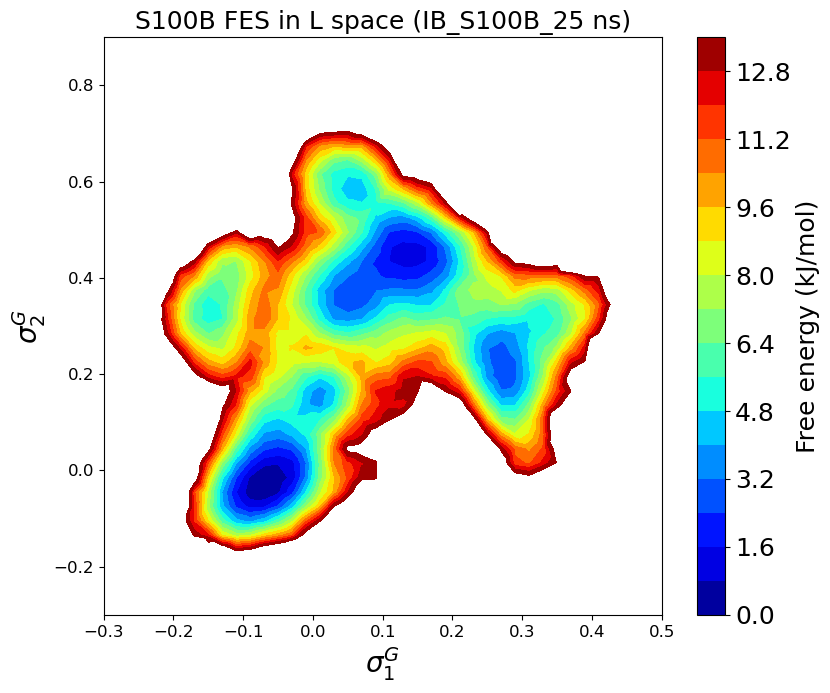

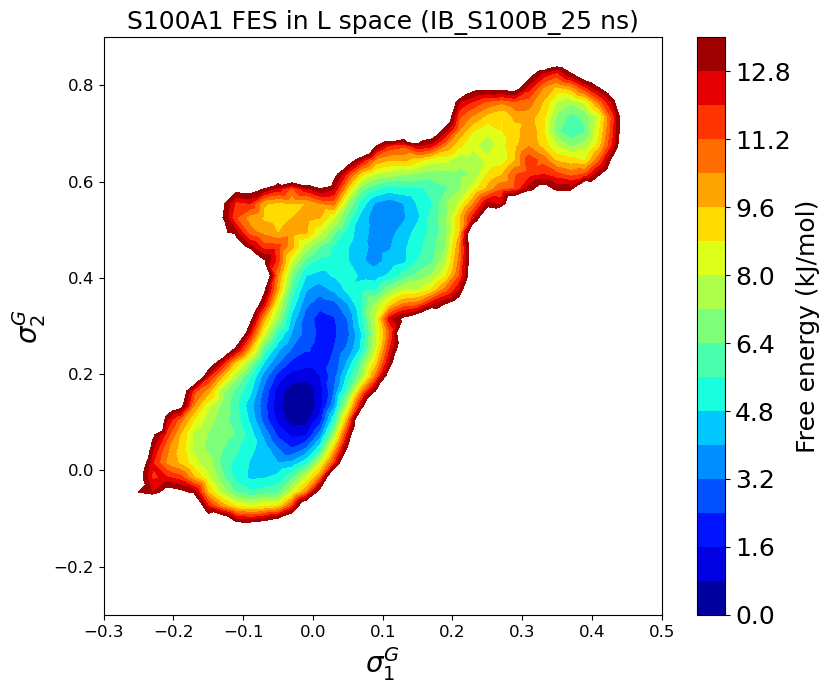

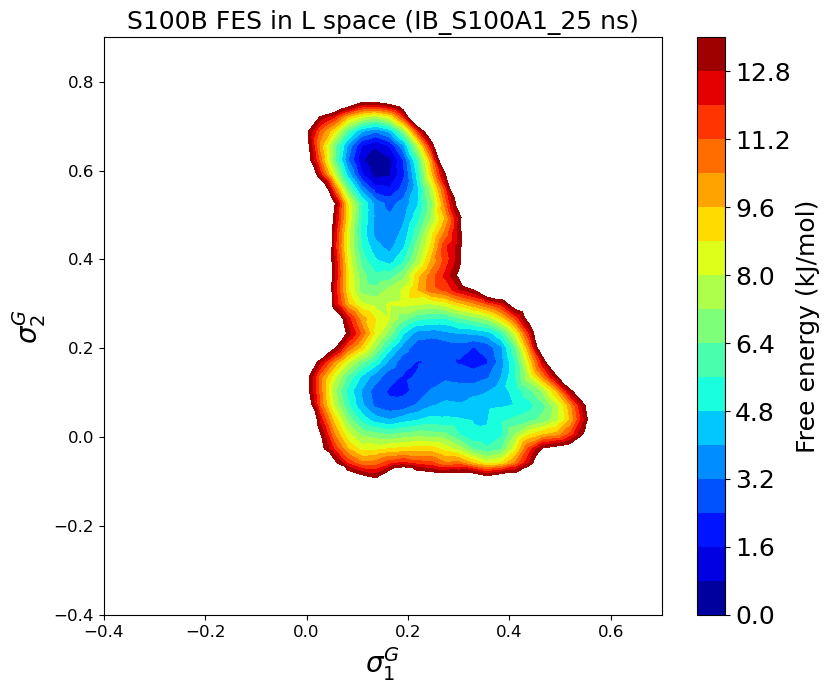

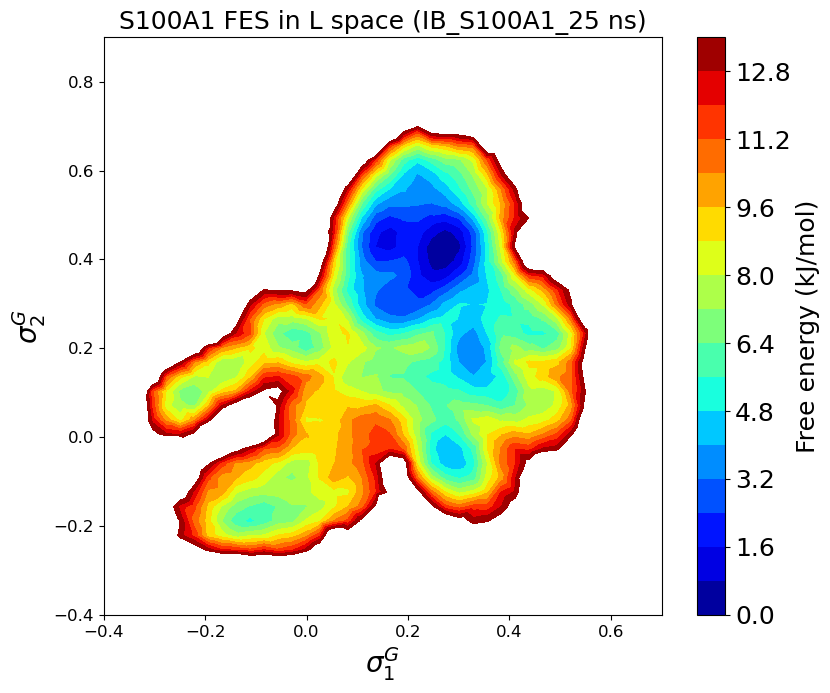

In [9]:
lag = 2500
dt = f"{int(lag*1e-2)} ns"
for ii, prot in enumerate(['S100B','S100A1']):
    for sys in ['S100B','S100A1']:

        prefix = f'{wkdir}/IB_{prot}_{lag}'
        
        file_path = f'{prefix}/{sys}_wham.sh'
        with open(file_path, 'r') as file:
            for line in file:
                lim_x = [float(line.split()[2]), float(line.split()[3])]
                lim_y = [float(line.split()[6]), float(line.split()[7])]

        a=pd.read_csv(f'{prefix}/{sys}_wham_pmf.txt', header=None, delim_whitespace=True, comment='#')

        a.columns = ['xx', 'yy', 'pmf','prob']
        b=a[a.pmf<9999]

        levels=np.arange(0, 14, 0.8)

        plt.figure(figsize=(9,7.5))
        ax = plt.gca()
        minp=np.min(b.pmf)
        CS = ax.tricontourf(b.xx, b.yy, b.pmf-minp, levels, cmap=plt.get_cmap('jet'))
        cbar = plt.colorbar(CS, ax=ax)
        cbar.ax.tick_params(labelsize=18)
        cbar.set_label(label='Free energy (kJ/mol)',size=18)

        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)

        plt.title(f'{sys} FES in L space (IB_{prot}_{dt})',y=1.0,fontsize=18)
        plt.xlabel("$\sigma_1^G$",fontsize=20)
        plt.ylabel("$\sigma_2^G$",fontsize=20)
        plt.xlim(lim_x)
        plt.ylim(lim_y)
        plt.savefig(f"{prefix}_wham_pmf.png",dpi=300)

/tmp/ipykernel_3235/553367560.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5,4))


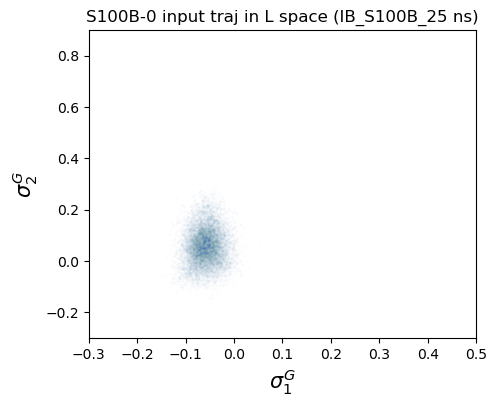

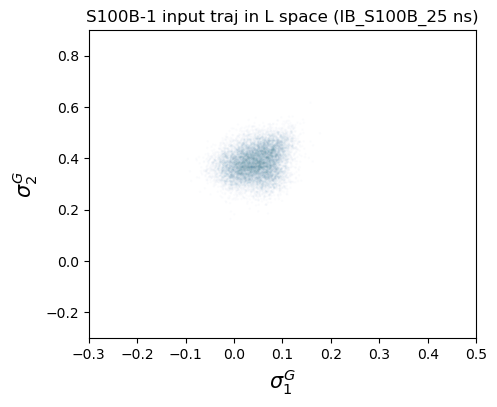

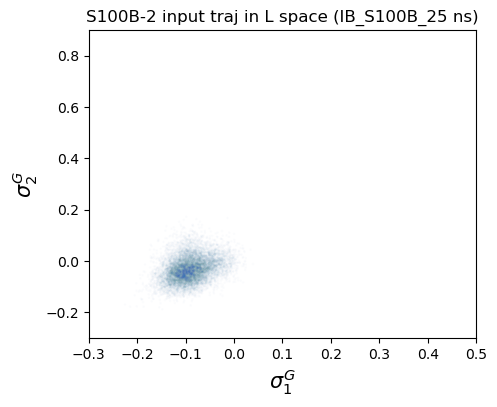

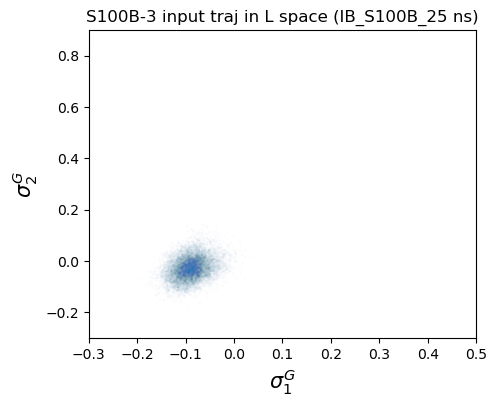

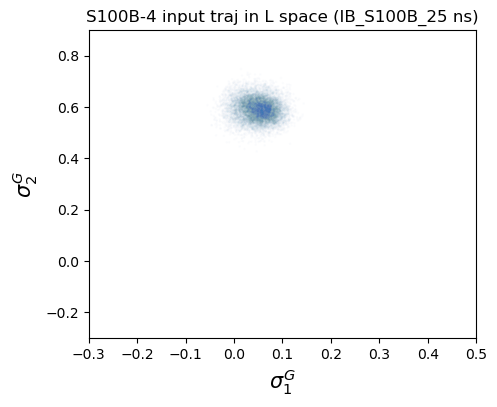

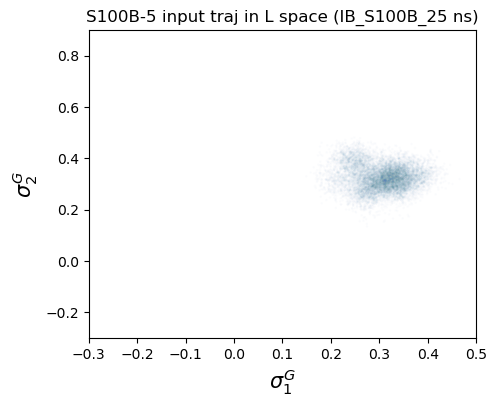

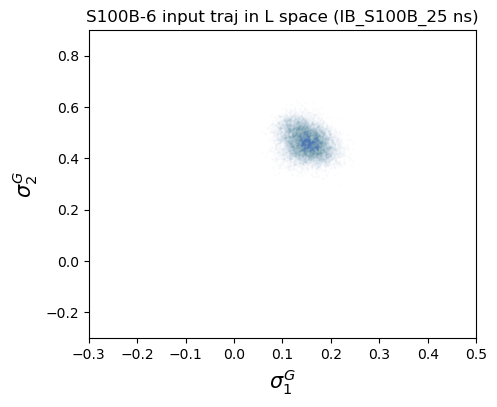

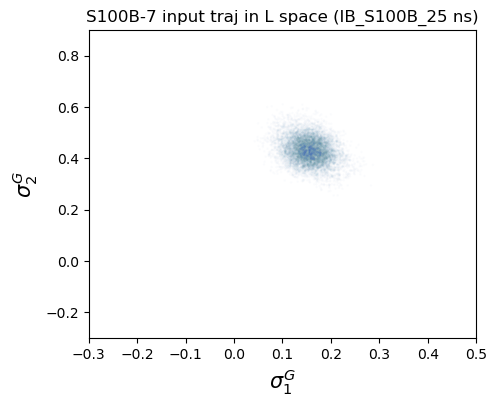

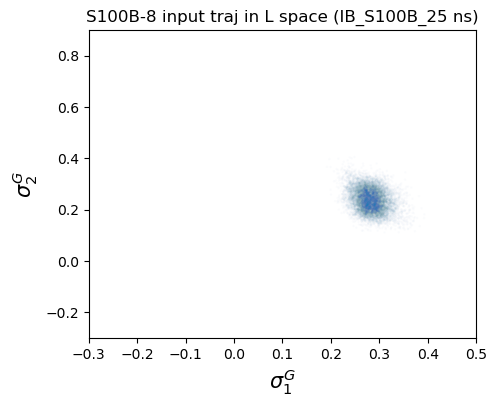

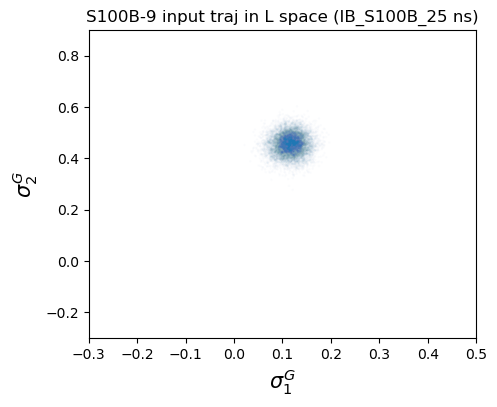

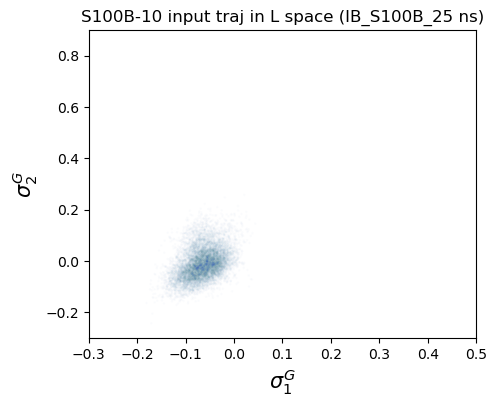

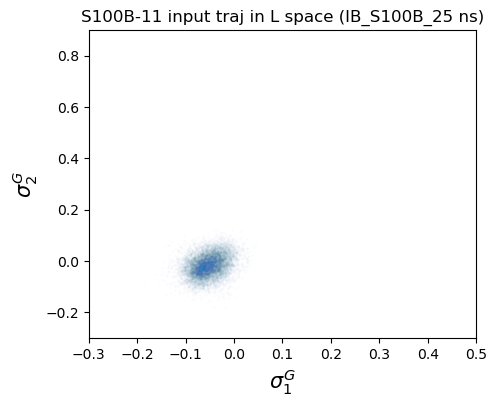

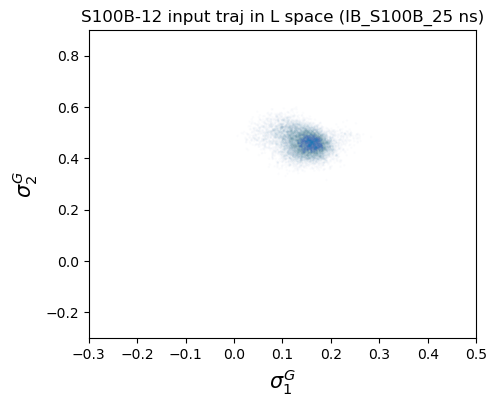

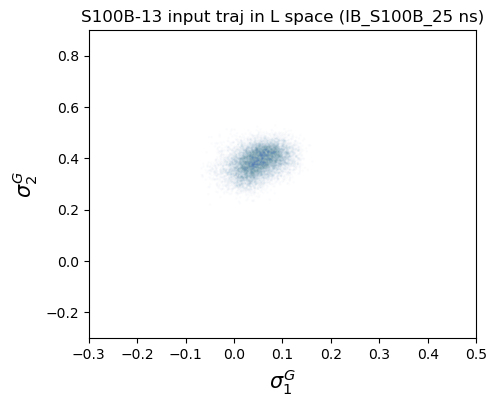

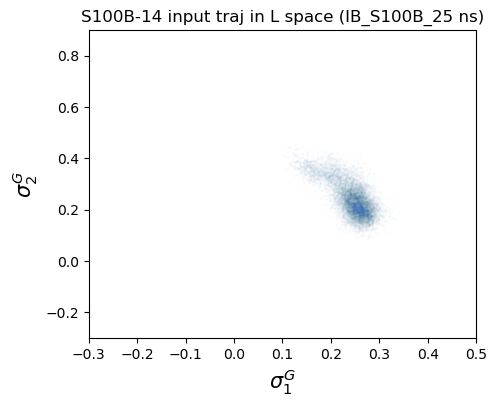

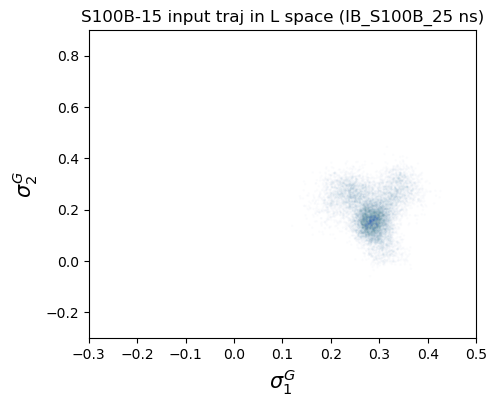

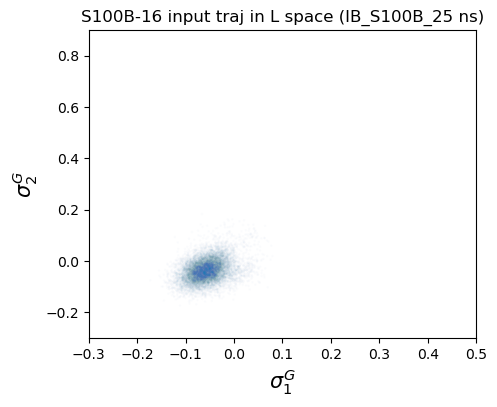

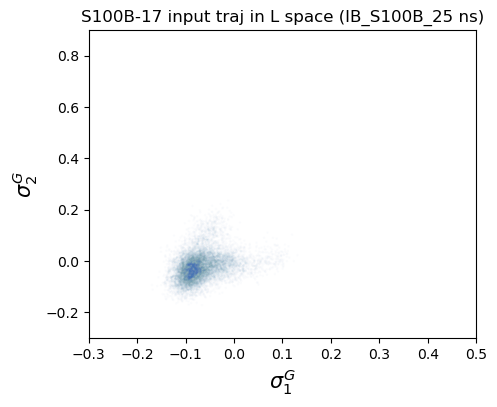

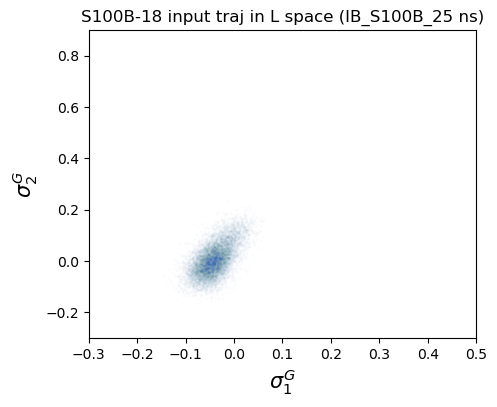

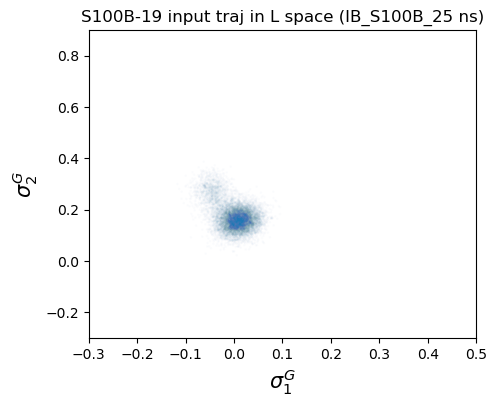

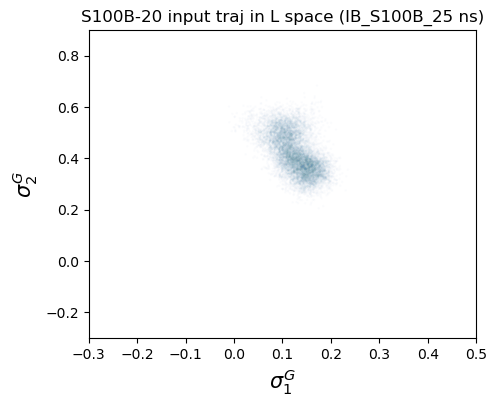

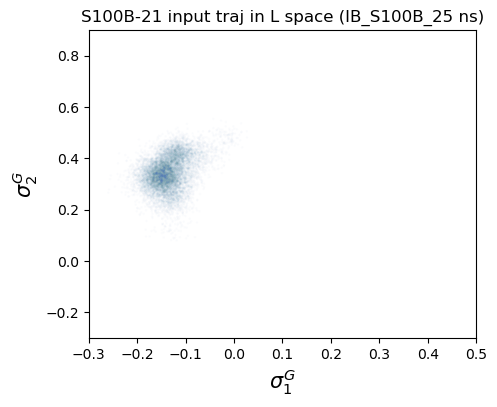

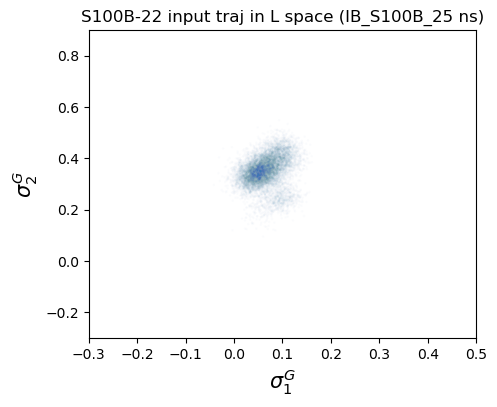

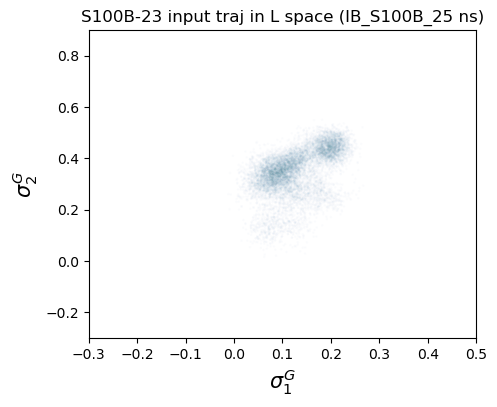

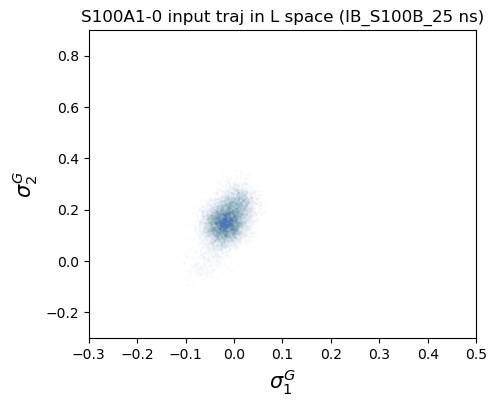

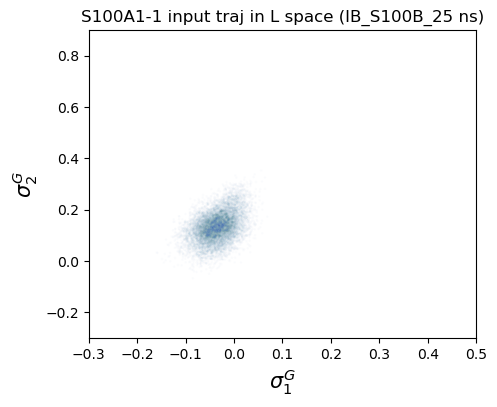

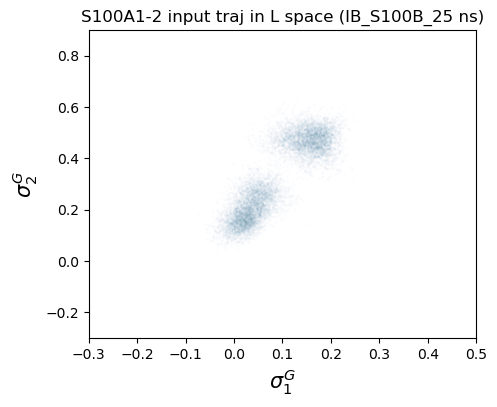

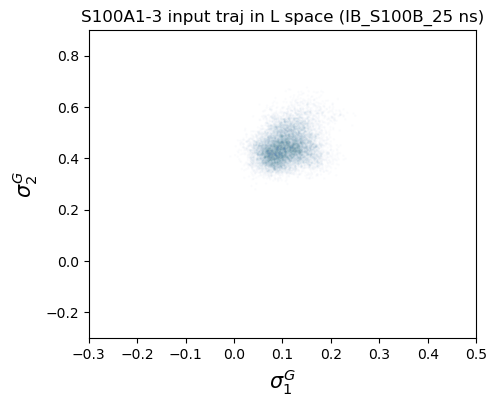

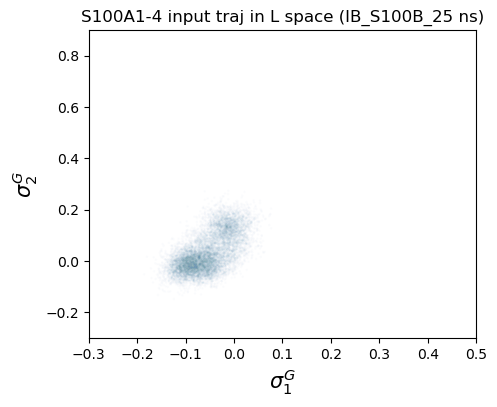

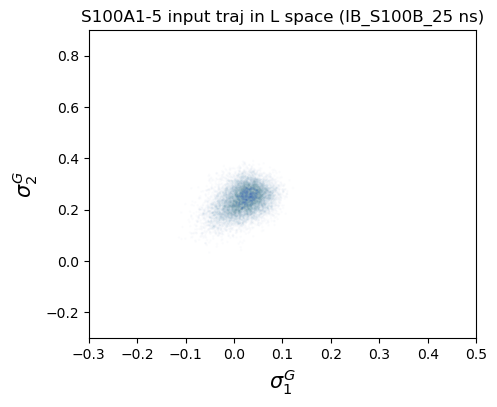

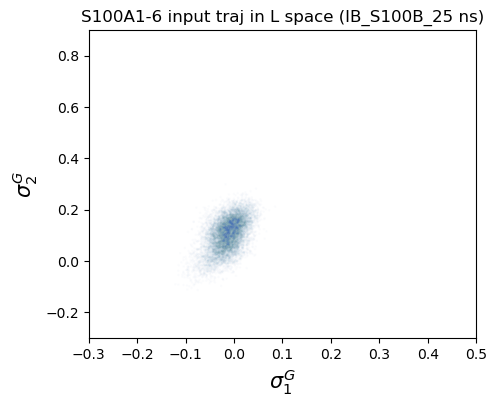

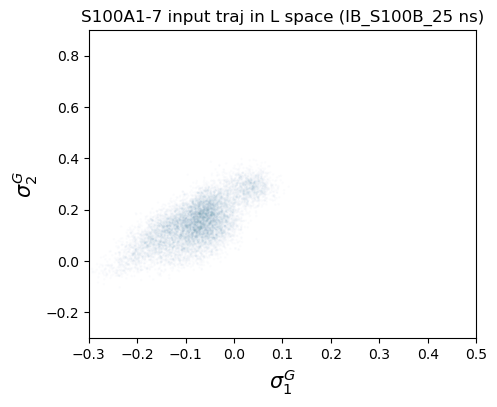

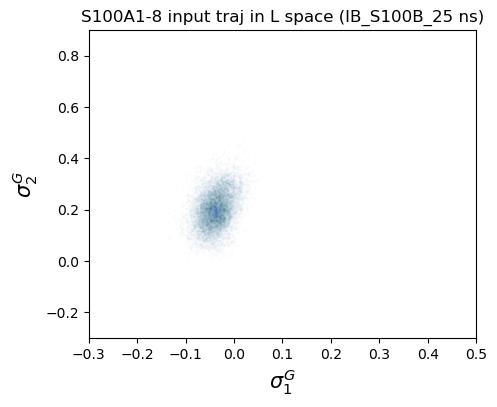

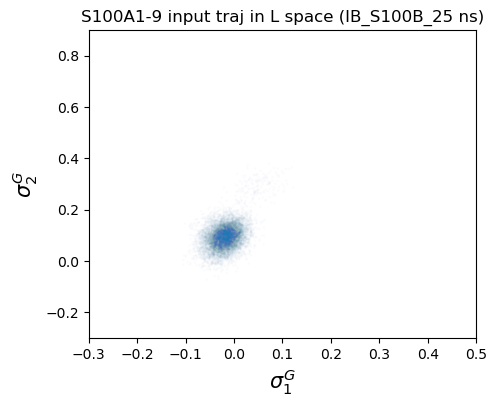

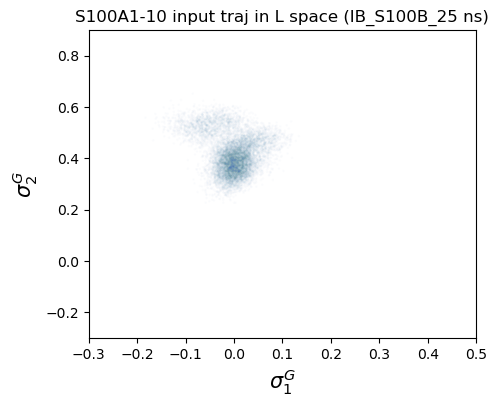

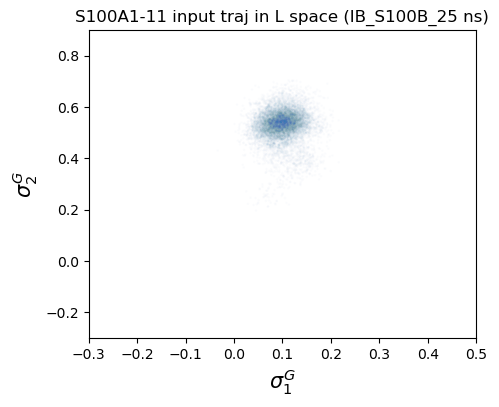

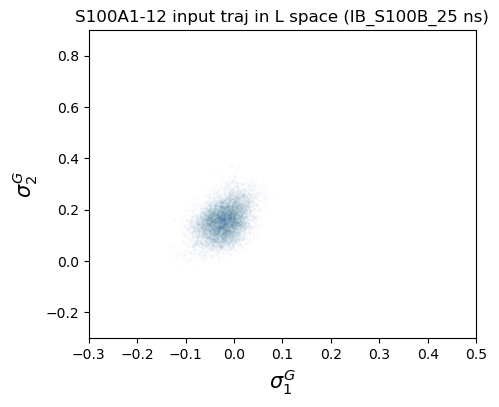

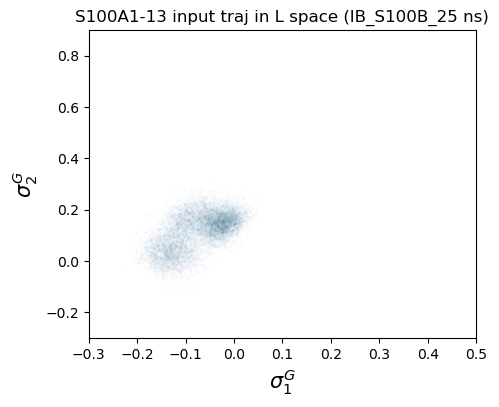

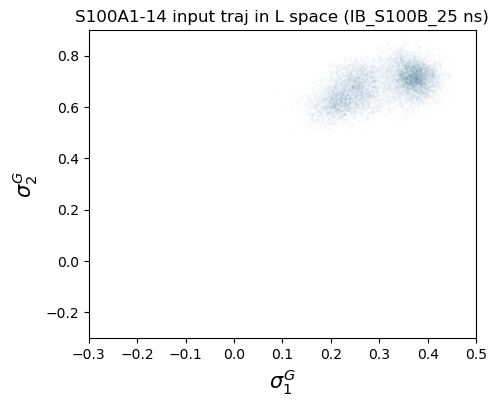

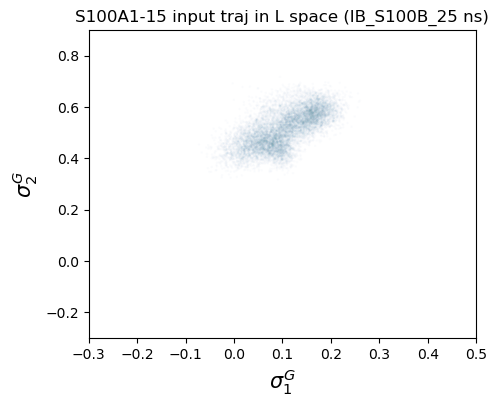

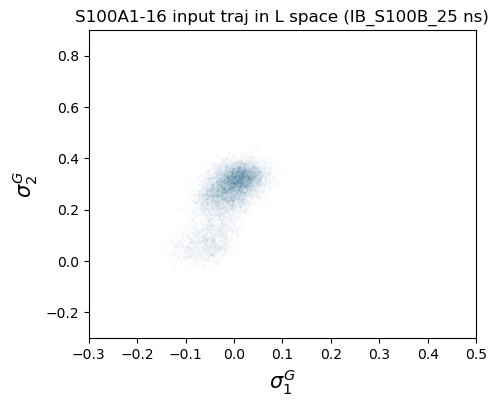

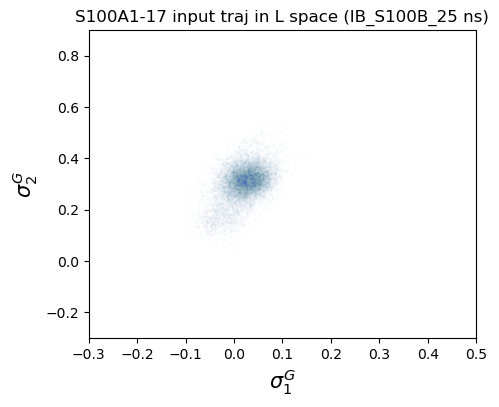

In [10]:
lag=2500
for ii, prot in enumerate(['S100B']):
    for sys in ['S100B','S100A1']:
        prefix = f'{wkdir}/IB_{prot}_{lag}'
        
        file_path = f'{prefix}/{sys}_wham.sh'
        with open(file_path, 'r') as file:
            for line in file:
                lim_x = [float(line.split()[2]), float(line.split()[3])]
                lim_y = [float(line.split()[6]), float(line.split()[7])]
        
        
        cv_files = glob.glob(f"{wkdir}/{sys}/{sys}_input/CVs*txt")       
        for fi in range(len(cv_files)):
            plt.figure(figsize=(5,4))
            IBs = np.loadtxt(f'{wkdir}/IB_{prot}_{lag}/{sys}_{fi}.txt')

            plot=plt.scatter(IBs[:,1],IBs[:,2],c=fi*np.ones(len(IBs)),s=1,alpha=0.01,cmap="tab20")
            plt.title(f'{sys}-{fi} input traj in L space (IB_{prot}_{dt})',y=1.0)
            plt.xlabel("$\sigma_1^G$",fontsize=15)
            plt.ylabel("$\sigma_2^G$",fontsize=15)
            plt.ylim(lim_y)
            plt.xlim(lim_x)
        # cbar = plt.colorbar(plot)
        # cbar.set_ticks([])

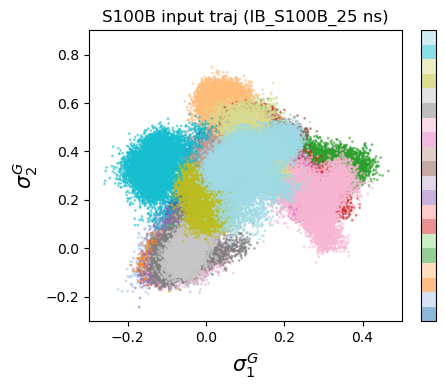

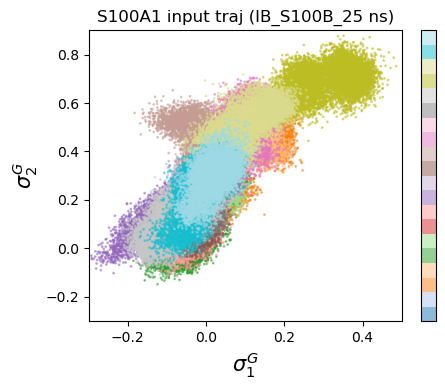

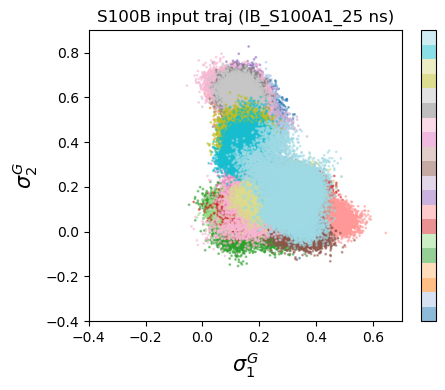

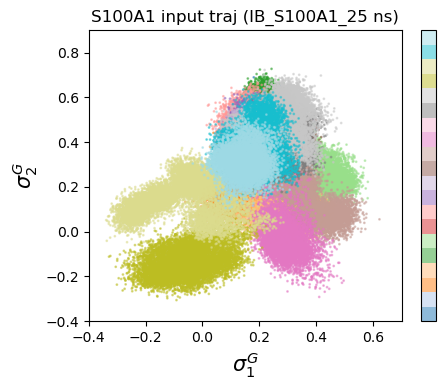

In [29]:
for ii, prot in enumerate(['S100B','S100A1']):
    for sys in ['S100B','S100A1']:
        prefix = f'{wkdir}/IB_{prot}_{lag}'
        
        file_path = f'{prefix}/{sys}_wham.sh'
        with open(file_path, 'r') as file:
            for line in file:
                lim_x = [float(line.split()[2]), float(line.split()[3])]
                lim_y = [float(line.split()[6]), float(line.split()[7])]
        
        
        cv_files = glob.glob(f"{wkdir}/{sys}/{sys}_input/CVs*txt")
        ls = []
        for fi in range(len(cv_files)):
            IBs = np.loadtxt(f'{wkdir}/IB_{prot}_{lag}/{sys}_{fi}.txt')
            ls.append(IBs[:,1:])

        ls_array=np.array(ls)
        ls_array=np.reshape(ls_array,(ls_array.shape[0]*ls_array.shape[1],ls_array.shape[2]))

        input_index=[np.ones(ls[i].shape[0],dtype=int)+i for i in range(len(cv_files))]
        input_index=np.array(input_index)
        input_color=np.reshape(input_index,(input_index.shape[0]*input_index.shape[1]))

        plt.figure(figsize=(5,4))
        plot=plt.scatter(ls_array.T[0],ls_array.T[1],c=input_color,s=1,alpha=0.5,cmap="tab20")
        plt.title(f'{sys} input traj (IB_{prot}_{dt})',y=1.0)
        plt.xlabel("$\sigma_1^G$",fontsize=15)
        plt.ylabel("$\sigma_2^G$",fontsize=15)
        plt.ylim(lim_y)
        plt.xlim(lim_x)
        cbar = plt.colorbar(plot)
        cbar.set_ticks([])
        plt.tight_layout()
        plt.savefig(f'{wkdir}/{sys}-input_IB_{prot}.png', dpi=300)

*IB_S100B_25ns is selected since it can distinguish outliers for both S100A1 and S100B*

**Determine G_basins for local SPIB**

In [30]:
# find basins given WHAM PMF file as input
def find_basins_on_FES(wham_file, pmf_cutoff=3):  # basin cutoff default: 3 kJ/mol
    offset = 0.0001 # a very small value to avoid any numerical issue in if conditions
    a=pd.read_csv(wham_file, header=None, delim_whitespace=True, comment='#')
    a.columns = ['xx', 'yy', 'pmf','prob']
    # identify bin size
    X = np.array(sorted(set(a['xx'].to_list())))
    bin0 = X[1]-X[0]
    Y = np.array(sorted(set(a['yy'].to_list())))
    bin1 = Y[1]-Y[0]
    
    b=a[a.pmf<pmf_cutoff]           
    G = nx.Graph()
    G.add_nodes_from(range(len(b)))  

    edges = []
    for i in range(len(b)):
        for j in range(i+1, len(b)):
            if (abs(b.iloc[i].xx - b.iloc[j].xx) > bin0+offset) or (abs(b.iloc[i].yy - b.iloc[j].yy) > bin1+offset):
                continue
            else:
                edges.append((i,j))
    G.add_edges_from(edges)

    groups = list(nx.connected_components(G))
    groups = sorted(groups, key=len, reverse=True)
    
    return b, groups, [bin0, bin1]

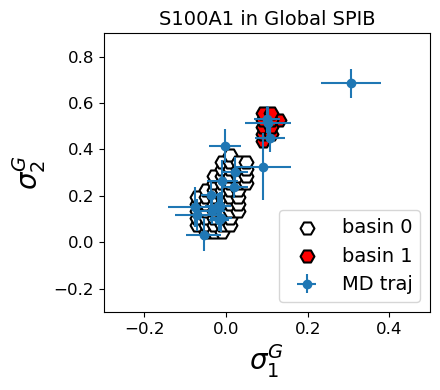

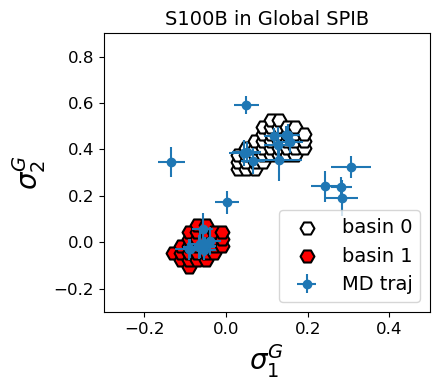

In [33]:
prefix=f"{wkdir}/IB_S100B_2500"
tmp_c = ['white', 'red']
# pmf_cutoffs=[3,3] # 3kJ/mol for S100A1, 3kJ/mol for S100B
pmf_cutoffs=[4,4] # 4kJ/mol for S100A1, 2kJ/mol for S100B

for isys, sys in enumerate(['S100A1', 'S100B']):  
    plt.figure(figsize=(4.5,4))
    file_path = f'{prefix}/{sys}_wham.sh'
    with open(file_path, 'r') as file:
        for line in file:
            lim_x = [float(line.split()[2]), float(line.split()[3])]
            lim_y = [float(line.split()[6]), float(line.split()[7])]    
    
    b, group, bins = find_basins_on_FES(f'{prefix}/{sys}_wham_pmf.txt', pmf_cutoff=pmf_cutoffs[isys])
    for ig, g in enumerate(group[:2]):
        plt.scatter(b.iloc[list(g)].xx, b.iloc[list(g)].yy,marker='H',linewidths=1.5,c=tmp_c[ig],edgecolors='black',s=100,label=f'basin {ig}') 

    mean = []
    std = []
    cv_files = glob.glob(f"{wkdir}/{sys}/{sys}_input/CVs*txt")
    for fi in range(len(cv_files)):
        IBs = np.loadtxt(f'{prefix}/{sys}_{fi}.txt')[:,1:]
        mean.append(np.mean(IBs,axis=0))
        std.append(np.std(IBs,axis=0))
    mean = np.array(mean)
    std = np.array(std)    
    plt.errorbar(mean[:,0], mean[:,1], xerr=std[:,0], yerr=std[:,1], fmt="o", label='MD traj')
    # plt.errorbar(mean[[-5],0], mean[[-5],1], xerr=std[[-5],0], yerr=std[[-5],1], fmt="o", label='MD traj')
    
    plt.ylim(lim_y)
    plt.xlim(lim_x)   
    plt.legend(fontsize=14)
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

    plt.title(f'{sys} in Global SPIB',y=1.0,fontsize=14)
    plt.xlabel("$\sigma_1^G$",fontsize=20)
    plt.ylabel("$\sigma_2^G$",fontsize=20)
    plt.tight_layout()
    # plt.savefig(f"{prefix}_Gbasins.png",dpi=300)

In [34]:
prefix=f"{wkdir}/IB_S100B_2500"
offset = 0.0001 # a very small value to avoid any numerical issue in if conditions
tol = 3
basin_traj = pd.DataFrame()
traj_n = []
traj_c = []
traj_b = []
traj_id = []
# pmf_cutoffs=[3,3] # 3kJ/mol for S100A1, 3kJ/mol for S100B
pmf_cutoffs=[4,4] # 4kJ/mol for S100A1, 2kJ/mol for S100B

for isys, sys in enumerate(['S100A1', 'S100B']): 
    f_nodt=open(f"{wkdir}/{sys}/{sys}_input/listindices.txt")
    lines=f_nodt.readlines()
    pdbs=[]
    chains=[]
    for word in lines[0].split('/home/xg23/scratch/S100_clean/rave/'):
        if word[:4] == 'S100':
            pdb = word.split('/')[0]
            chain = word.split('/')[1][4]
            pdbs.append(pdb)
            chains.append(chain)      
    
    mean = []
    std = []
    cv_files = glob.glob(f"{wkdir}/{sys}/{sys}_input/CVs*txt")
    for fi in range(len(cv_files)):
        IBs = np.loadtxt(f'{prefix}/{sys}_{fi}.txt')[:,1:]
        mean.append(np.mean(IBs,axis=0))
        std.append(np.std(IBs,axis=0))
    mean = np.array(mean)
    std = np.array(std)    
    
    b, groups, bins = find_basins_on_FES(f'{prefix}/{sys}_wham_pmf.txt', pmf_cutoff=pmf_cutoffs[isys])
    for ig, g in enumerate(groups[:2]): 
        array = np.transpose([np.array(b.iloc[list(g)].xx), np.array(b.iloc[list(g)].yy)])
        # find the 3 MD trajs with their mean values closest to pmf minimum for each basin
        bmin = np.argmin(b.iloc[list(g)].pmf.values)
        b_minIB = [b.iloc[list(g)[bmin]].xx, b.iloc[list(g)[bmin]].yy]
        distances = np.linalg.norm(mean - b_minIB, axis=1)
        mean_id = np.argsort(distances)[:3]
        for i in mean_id:            
            check = mean[i]            
            if (abs(check[0] - b_minIB[0]) > tol*bins[0]+offset) or (abs(check[1] - b_minIB[1]) > tol*bins[1]+offset):
                continue
                
            check = mean[i] + np.array([0, std[i][1]])
            if (abs(check[0] - b_minIB[0]) > tol*bins[0]+offset) or (abs(check[1] - b_minIB[1]) > tol*bins[1]+offset):
                continue
                
            check = mean[i] + np.array([0, -std[i][1]])
            if (abs(check[0] - b_minIB[0]) > tol*bins[0]+offset) or (abs(check[1] - b_minIB[1]) > tol*bins[1]+offset):
                continue
            
            check = mean[i] + np.array([std[i][0], 0])
            if (abs(check[0] - b_minIB[0]) > tol*bins[0]+offset) or (abs(check[1] - b_minIB[1]) > tol*bins[1]+offset):
                continue
            
            check = mean[i] + np.array([-std[i][0], 0])
            if (abs(check[0] - b_minIB[0]) > tol*bins[0]+offset) or (abs(check[1] - b_minIB[1]) > tol*bins[1]+offset):
                continue           
     
            traj_id.append(i)
            traj_n.append(pdbs[i])
            traj_c.append(chains[i])
            traj_b.append(ig)                    
basin_traj['name']=traj_n
basin_traj['chain']=traj_c
basin_traj['basin']=traj_b    
basin_traj['input_id']=traj_id   
# basin_traj.to_csv(f'{wkdir}/basin_traj.csv',index=False)        

In [15]:
basin_traj

name chain  basin  input_id
0    S100A1_1_ca     B      0         0
1  S100A1_255_ca     B      0        12
2    S100A1_1_ca     A      0         1
3  S100A1_256_ca     A      1        11
4   S100B_163_ca     B      0        16
5   S100B_113_ca     B      0         2
6   S100B_163_ca     A      0        17
7   S100B_137_ca     A      1         9
8   S100B_165_ca     B      1        12
9   S100B_149_ca     B      1         6

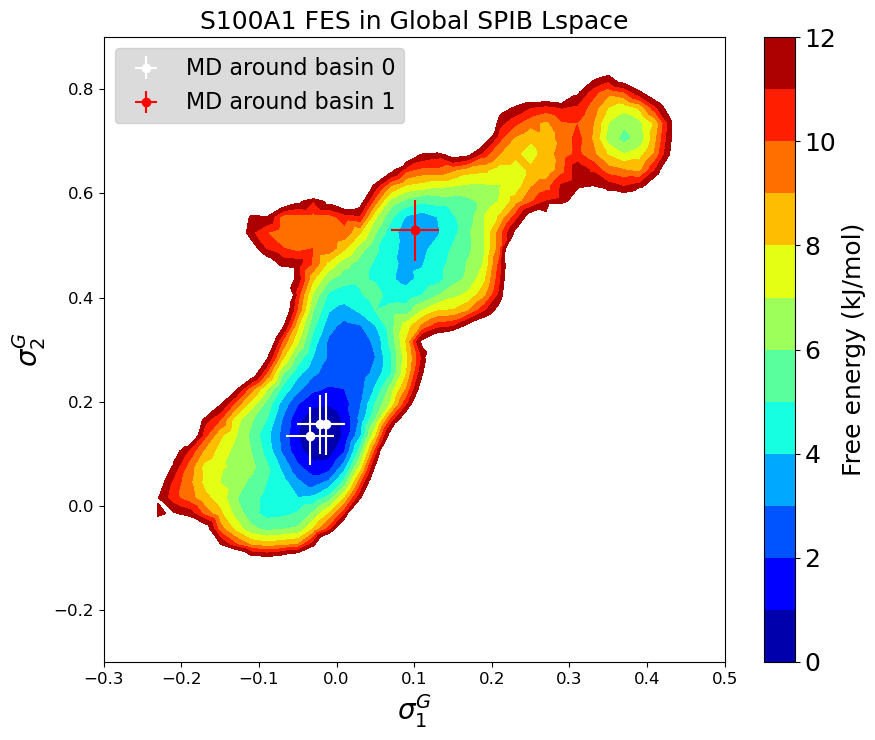

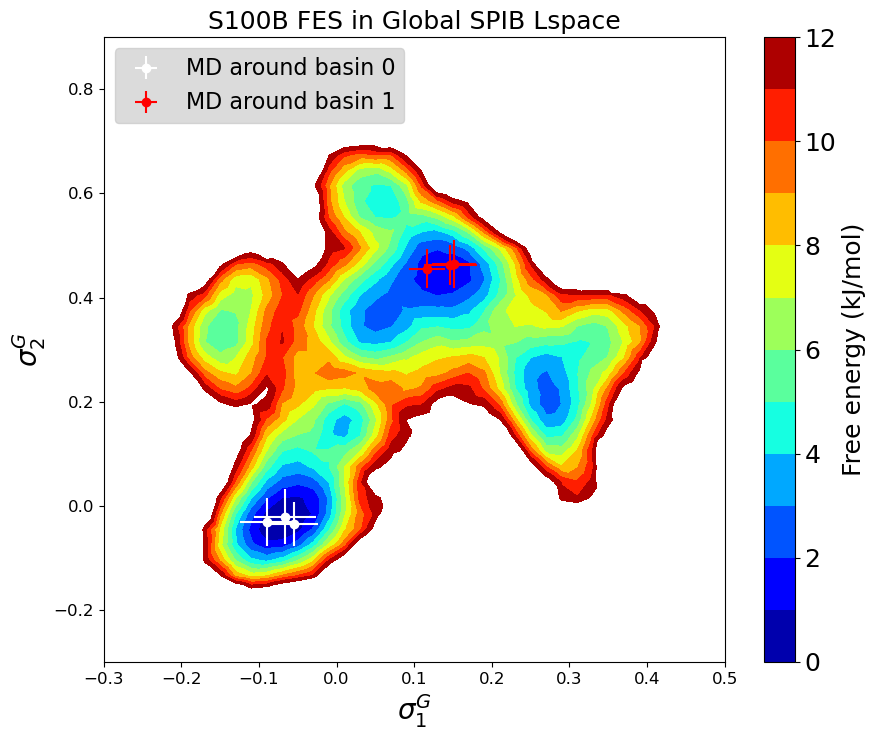

In [36]:
prefix=f"{wkdir}/IB_S100B_2500"
tmp_c = ['white', 'red']
basin_traj = pd.read_csv(f'{wkdir}/basin_traj.csv')
for sys in ['S100A1', 'S100B']:  
    file_path = f'{prefix}/{sys}_wham.sh'
    with open(file_path, 'r') as file:
        for line in file:
            lim_x = [float(line.split()[2]), float(line.split()[3])]
            lim_y = [float(line.split()[6]), float(line.split()[7])]    
    
    plt.figure(figsize=(9,7.5))
    ax = plt.gca() 
    a = pd.read_csv(f'{prefix}/{sys}_wham_pmf.txt', header=None, delim_whitespace=True, comment='#') 
    a.columns = ['xx', 'yy', 'pmf','prob']
    btmp=a[a.pmf<9999]
    levels=np.arange(0, 13, 1)

    minp=np.min(btmp.pmf)
    CS = ax.tricontourf(btmp.xx, btmp.yy, btmp.pmf-minp, levels, cmap=plt.get_cmap('jet'))
    cbar = plt.colorbar(CS, ax=ax)
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label(label='Free energy (kJ/mol)',size=18)  
    
    
    mean = []
    std = []
    cv_files = glob.glob(f"{wkdir}/{sys}/{sys}_input/CVs*txt")
    for fi in range(len(cv_files)):
        IBs = np.loadtxt(f'{prefix}/{sys}_{fi}.txt')[:,1:]
        mean.append(np.mean(IBs,axis=0))
        std.append(np.std(IBs,axis=0))
    mean = np.array(mean)
    std = np.array(std)  
    
    for ig in range(2):
        df_tmp = basin_traj[(basin_traj.name.str.split('_').str[0]==sys) & (basin_traj.basin == ig)]
        traj_id = list(df_tmp.input_id)
        plt.errorbar(mean[traj_id,0], mean[traj_id,1], xerr=std[traj_id,0], yerr=std[traj_id,1], fmt='o', c=tmp_c[ig], label=f'MD around basin {ig}')
        
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

    plt.title(f'{sys} FES in Global SPIB Lspace',y=1.0,fontsize=18)
    plt.xlabel("$\sigma_1^G$",fontsize=20)
    plt.ylabel("$\sigma_2^G$",fontsize=20)
    plt.ylim(lim_y)
    plt.xlim(lim_x)   
    plt.legend(fontsize=16, loc='upper left',facecolor="lightgray")
    plt.tight_layout()
    plt.savefig(f"{wkdir}/{sys}_MD_b.png",dpi=300)           

**SPIB intepretation**

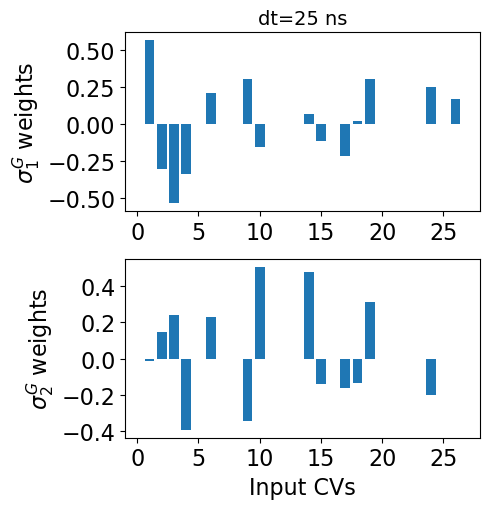

In [51]:
lag = 2500
dt = f"{int(lag*1e-2)} ns"
prot = 'S100B'

op_id = [int(x) for x in np.loadtxt(f"{wkdir}/G_spib_op_id.txt")]
op_max = np.load(f"{wkdir}/{prot}/{prot}_input/max_unb.npy")
op_min = np.load(f"{wkdir}/{prot}/{prot}_input/min_unb.npy")    
prefix=f"{wkdir}/{prot}/dt-{lag}/SPIB/Unweighted_d=2_t={lag}_{hyper}"
weights=np.load(prefix+"z_mean_encoder_weight0.npy")
# n_weights = weights/(op_max-op_min)
n_weights = weights
plt.figure(figsize=(5,5.2))
plt.subplot(2,1,1)
plt.bar(op_id,n_weights[0])
plt.ylabel("$\sigma_1^G$ weights", fontsize=16)
plt.title(f"dt={dt}", fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(-1,28)
#plt.tight_layout()
plt.subplot(2,1,2)
plt.bar(op_id,n_weights[1])
plt.ylabel("$\sigma_2^G$ weights", fontsize=16)
plt.xlabel("Input CVs", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(-1,28)
plt.tight_layout()
# plt.savefig(f"{wkdir}/weights_{prot}_{lag}.png",dpi=300)

In [7]:
ends = [int(i) for i in np.loadtxt('/home/xgu/Tiwary/S100_clean/ends.index')]
res_pairs = []
for i in range(len(ends)):
    for j in range(i+1, len(ends)):
        res_pairs.append([ends[i], ends[j]])
res_pairs = np.asarray(res_pairs)

In [44]:
Pairs = []
Wts = []
weights=np.load(prefix+"z_mean_encoder_weight0.npy")
for IB_i in range(len(weights)):
    pairs = []
    wts = []
    maxw = np.max(abs(weights[IB_i]))
    for i in range(len(weights[IB_i])):
        if (abs(weights[IB_i][i]) >= 0.5*maxw):
            pairs.append(list(res_pairs[op_id[i]]))
            wts.append(weights[IB_i][i]/maxw)
    Pairs.append(pairs)
    Wts.append(wts)

In [45]:
Pairs[0]

[[1, 29], [1, 39], [1, 51], [1, 60], [17, 51], [39, 60]]

In [47]:
Wts[0]

[1.0, -0.5522336, -0.9557012, -0.6042481, 0.5418205, 0.5410312]

In [50]:
np.sign(Wts[0])

array([ 1., -1., -1., -1.,  1.,  1.], dtype=float32)

In [48]:
Pairs[1]

[[1, 60], [17, 51], [17, 60], [29, 51], [39, 60]]

In [49]:
Wts[1]

[-0.7727191, -0.6745138, 1.0, 0.9407903, 0.6223178]

**Projection on G_SPIB latent space**

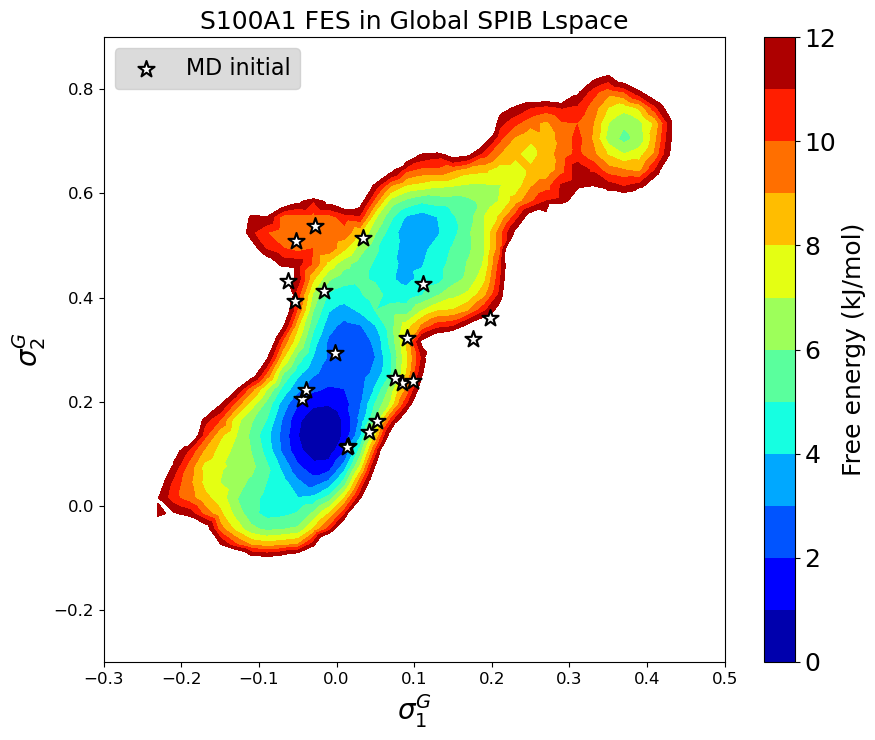

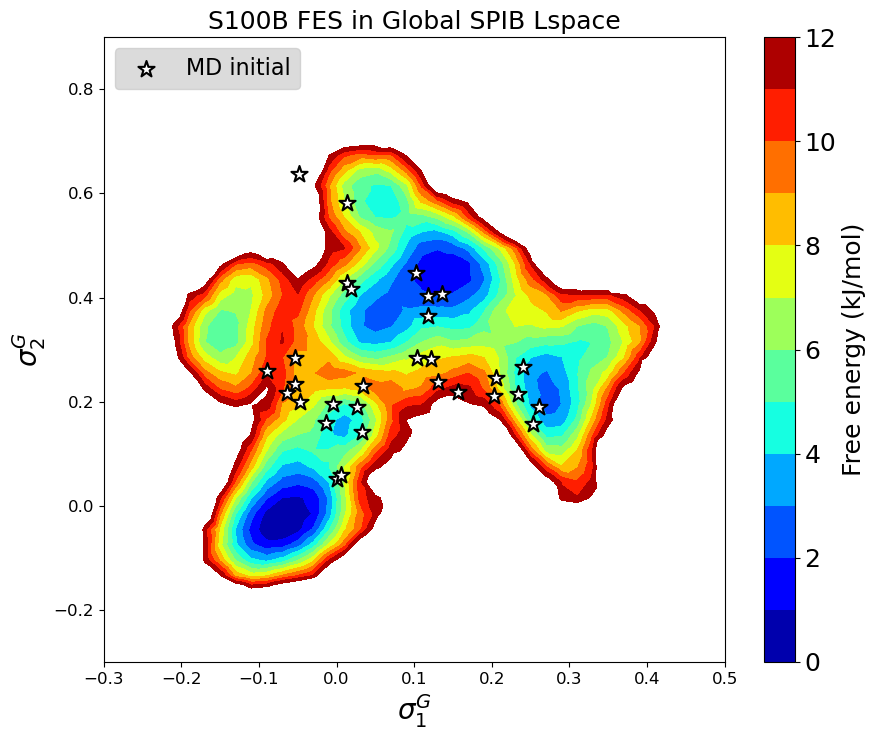

In [22]:
# Project initial structures of MD trajs
prefix=f"{wkdir}/IB_S100B_2500"
tmp_c = ['white', 'red']

lag = 2500
dt = f"{int(lag*1e-2)} ns"
prot = 'S100B'

op_id = [int(x) for x in np.loadtxt(f"{wkdir}/G_spib_op_id.txt")]
op_max = np.load(f"{wkdir}/{prot}/{prot}_input/max_unb.npy")
op_min = np.load(f"{wkdir}/{prot}/{prot}_input/min_unb.npy")    
weights=np.load(f"{wkdir}/{prot}/dt-{lag}/SPIB/Unweighted_d=2_t={lag}_{hyper}z_mean_encoder_weight0.npy")

for sys in ['S100A1', 'S100B']:  
    file_path = f'{prefix}/{sys}_wham.sh'
    with open(file_path, 'r') as file:
        for line in file:
            lim_x = [float(line.split()[2]), float(line.split()[3])]
            lim_y = [float(line.split()[6]), float(line.split()[7])]    
    
    plt.figure(figsize=(9,7.5))
    ax = plt.gca() 
    a = pd.read_csv(f'{prefix}/{sys}_wham_pmf.txt', header=None, delim_whitespace=True, comment='#') 
    a.columns = ['xx', 'yy', 'pmf','prob']
    btmp=a[a.pmf<9999]
    levels=np.arange(0, 13, 1)

    minp=np.min(btmp.pmf)
    CS = ax.tricontourf(btmp.xx, btmp.yy, btmp.pmf-minp, levels, cmap=plt.get_cmap('jet'))
    cbar = plt.colorbar(CS, ax=ax)
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label(label='Free energy (kJ/mol)',size=18)  
    
    Dist = []
    ini_pdbs = glob.glob(f'/home/xgu/Tiwary/S100_clean/unbiasedMD/{sys}_*_ca/init.pdb')
    for ini in ini_pdbs:
        traj = md.load(ini)    
        distA, distB = scv.anchor_pairDist(traj)
        dist = [distA, distB]
        dist = np.concatenate(dist)
        Dist.extend(dist)
    Dist = np.array(Dist)
    cv = Dist[:,op_id]
    cv_norm = (cv-op_min)/(op_max-op_min)
    ini_IB = np.dot(cv_norm, weights.T)
    plt.scatter(ini_IB.T[0],ini_IB.T[1],marker='*',linewidths=1.5,c='white',edgecolors='black',s=150,label='MD initial') 

     
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

    plt.title(f'{sys} FES in Global SPIB Lspace',y=1.0,fontsize=18)
    plt.xlabel("$\sigma_1^G$",fontsize=20)
    plt.ylabel("$\sigma_2^G$",fontsize=20)
    plt.ylim(lim_y)
    plt.xlim(lim_x)   
    plt.legend(fontsize=16, loc='upper left',facecolor="lightgray")
    plt.tight_layout()
    # plt.savefig(f"{wkdir}/{sys}_MD_b.png",dpi=300)   

S100A1_1_ca B
S100A1_1_ca A
S100A1_253_ca B
S100A1_253_ca A
S100A1_252_ca B
S100A1_252_ca A
S100A1_240_ca B
S100A1_240_ca A
S100A1_249_ca B
S100A1_249_ca A
S100A1_256_ca B
S100A1_256_ca A
S100A1_255_ca B
S100A1_255_ca A
S100A1_243_ca B
S100A1_243_ca A
S100A1_232_ca B
S100A1_232_ca A
S100B_116_ca B
S100B_116_ca A
S100B_113_ca B
S100B_113_ca A
S100B_155_ca B
S100B_155_ca A
S100B_149_ca B
S100B_149_ca A
S100B_137_ca B
S100B_137_ca A
S100B_161_ca B
S100B_161_ca A
S100B_165_ca B
S100B_165_ca A
S100B_157_ca B
S100B_157_ca A
S100B_163_ca B
S100B_163_ca A
S100B_1_ca B
S100B_1_ca A
S100B_0_ca B
S100B_0_ca A
S100B_162_ca B
S100B_162_ca A


/tmp/ipykernel_72/2602834549.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(4,4))


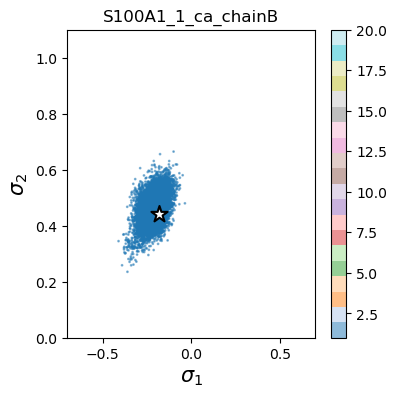

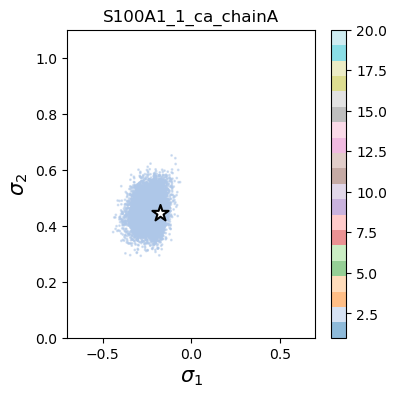

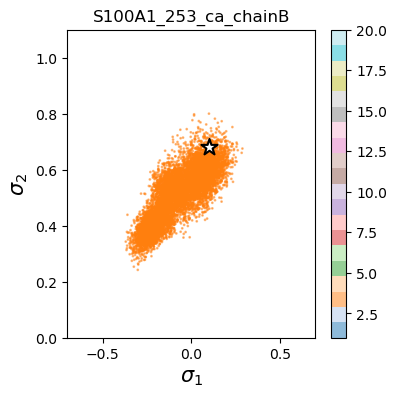

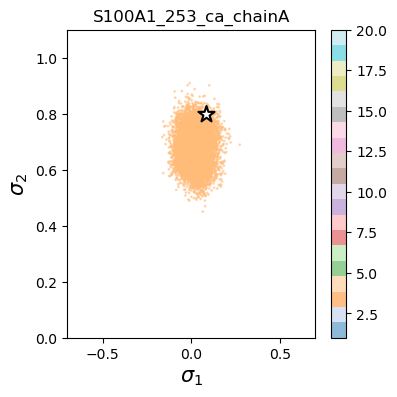

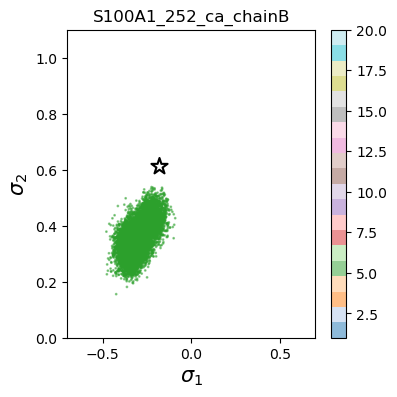

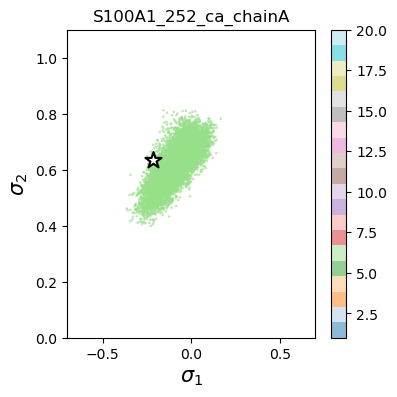

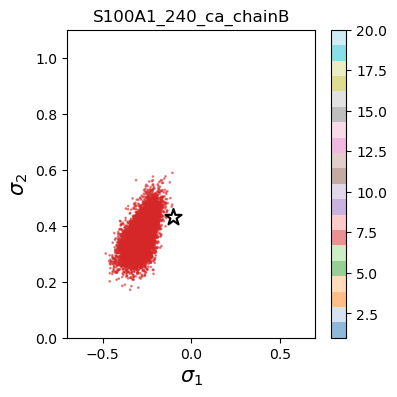

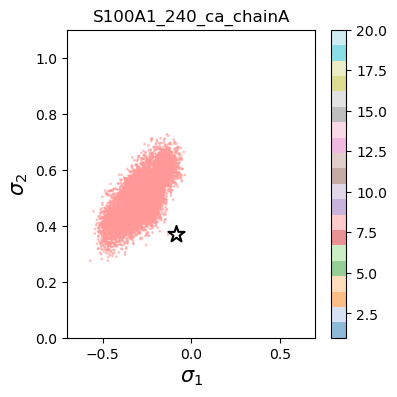

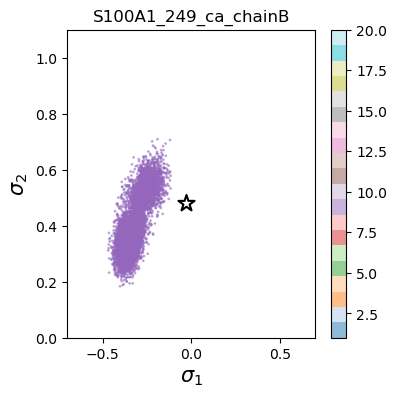

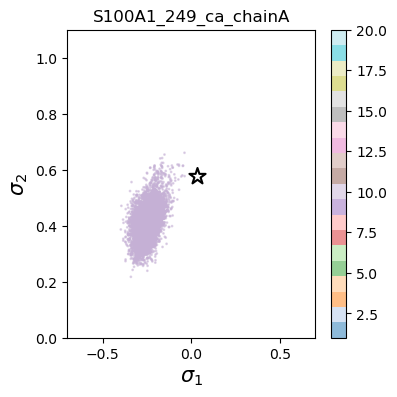

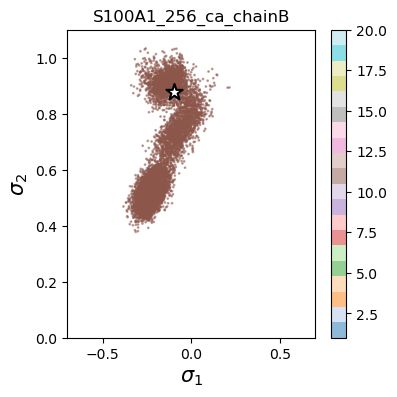

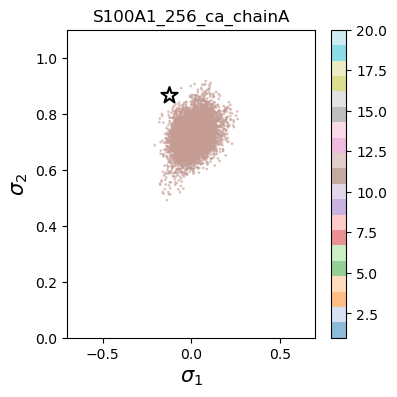

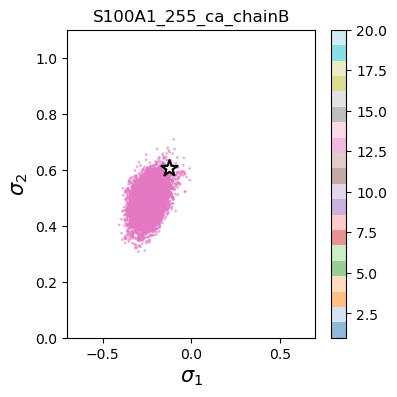

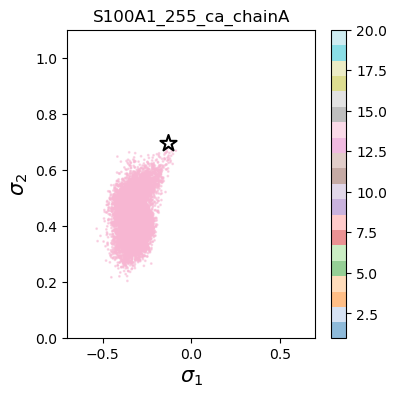

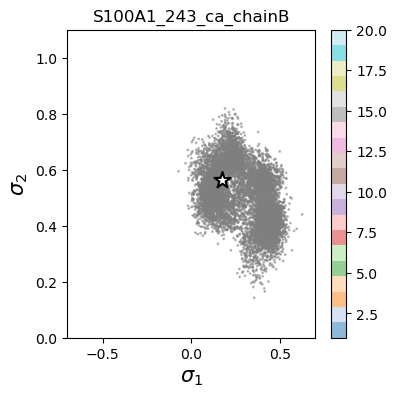

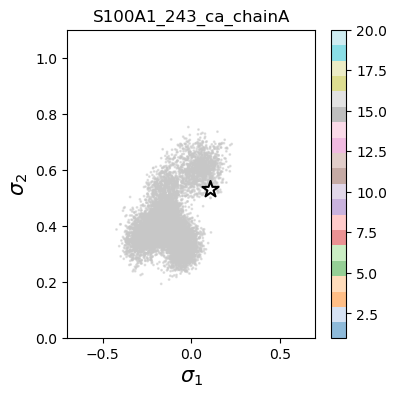

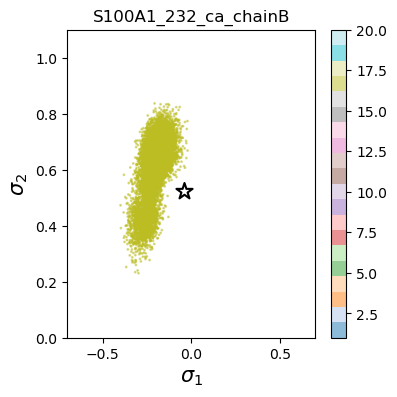

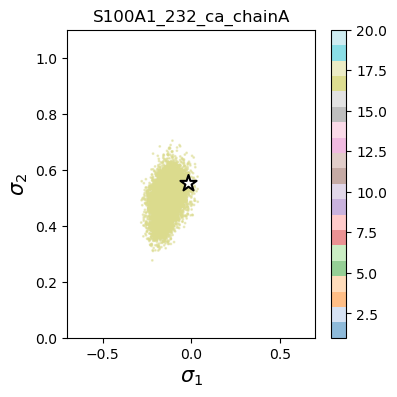

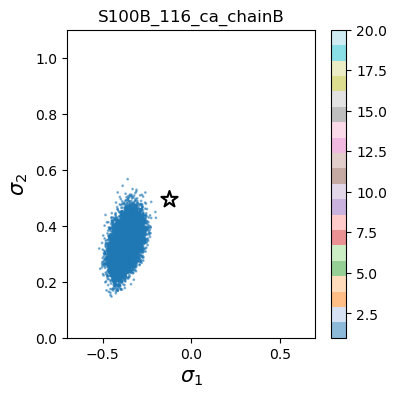

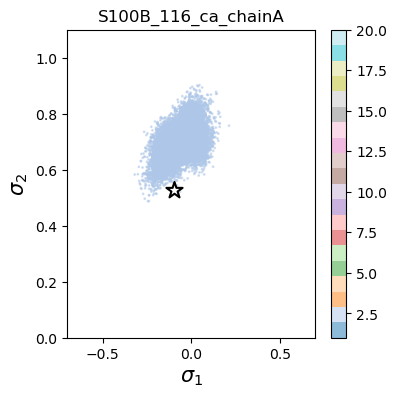

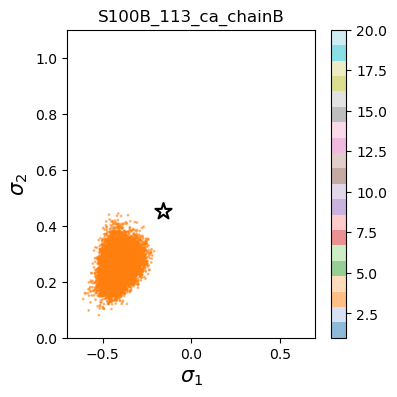

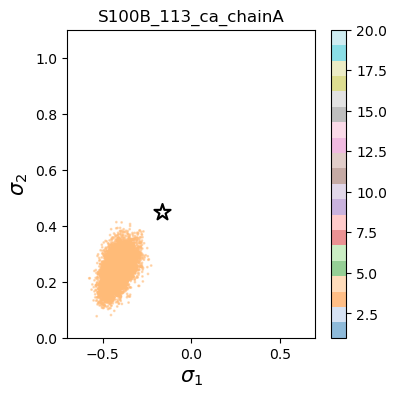

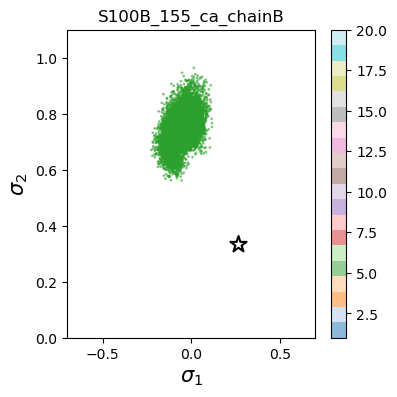

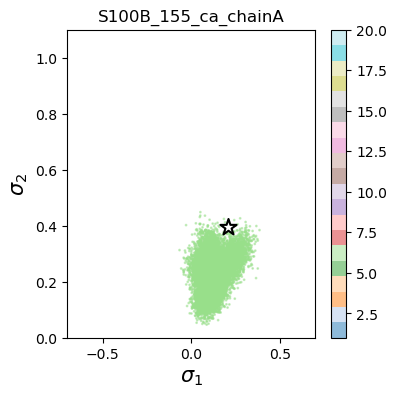

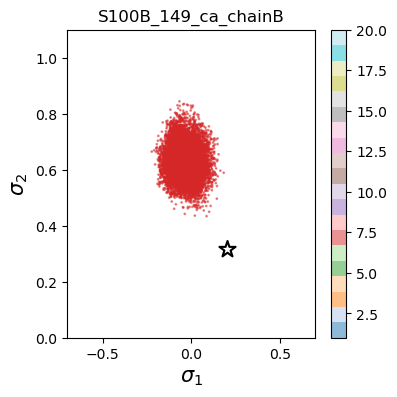

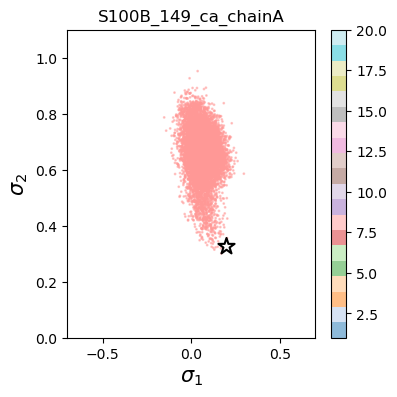

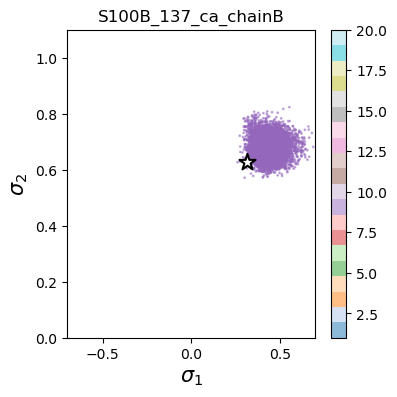

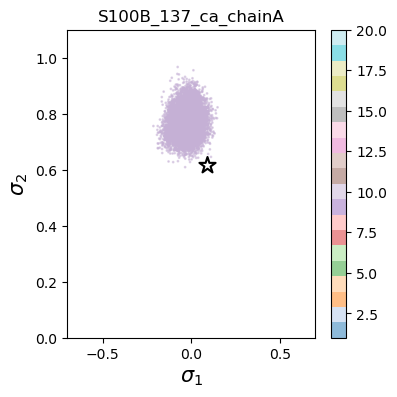

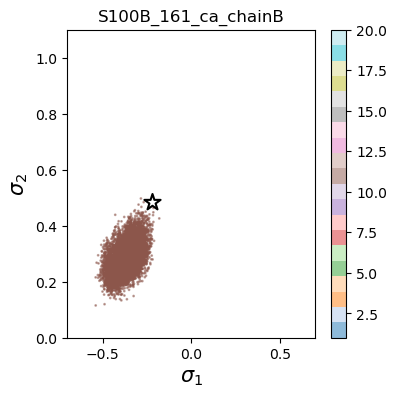

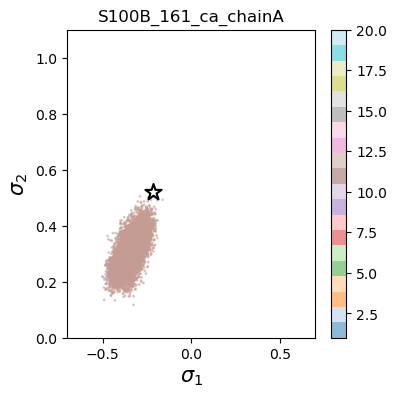

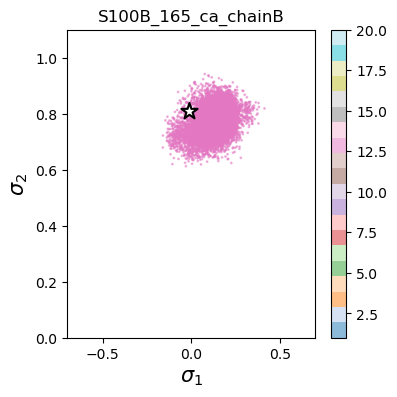

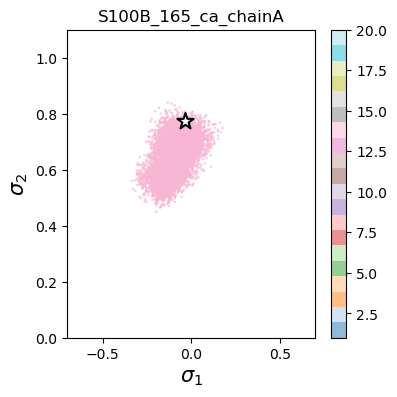

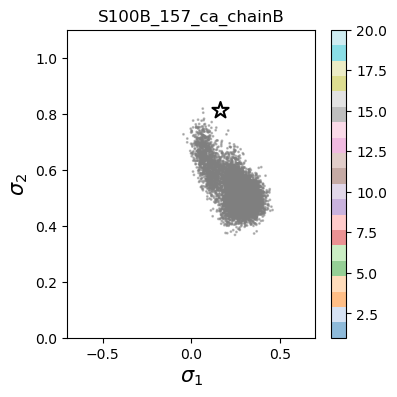

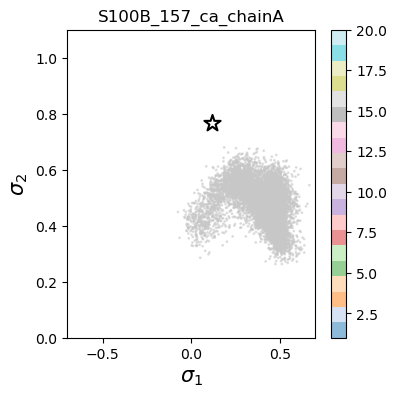

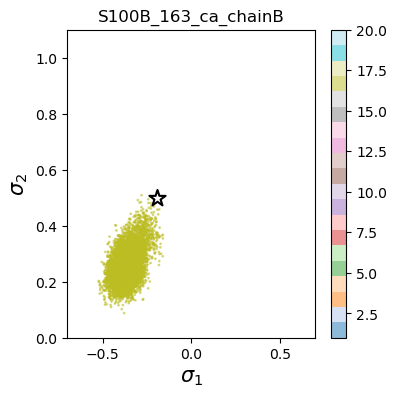

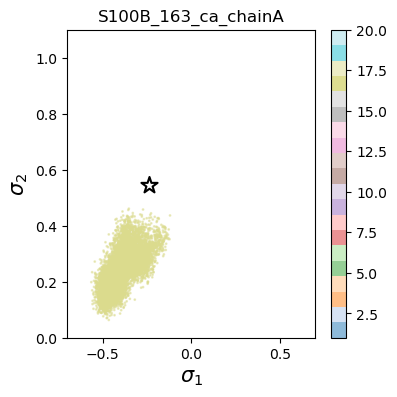

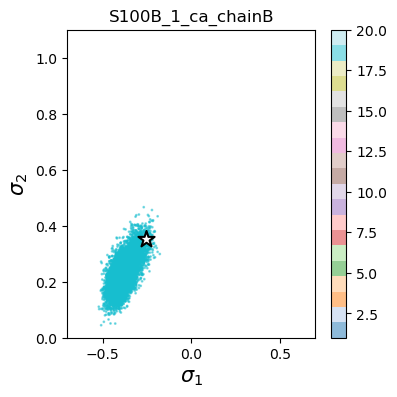

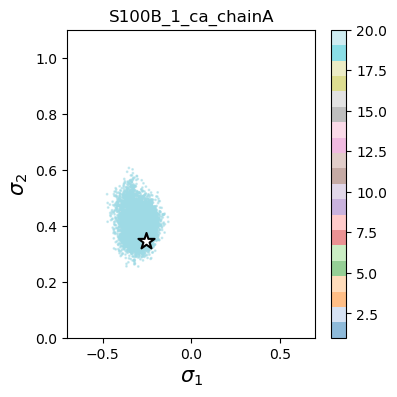

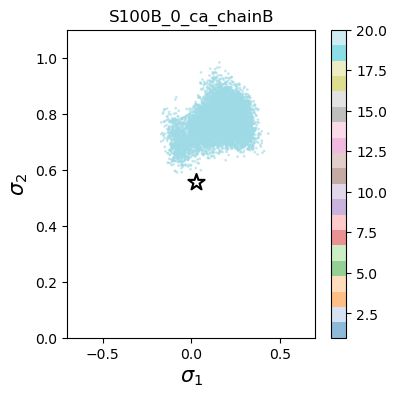

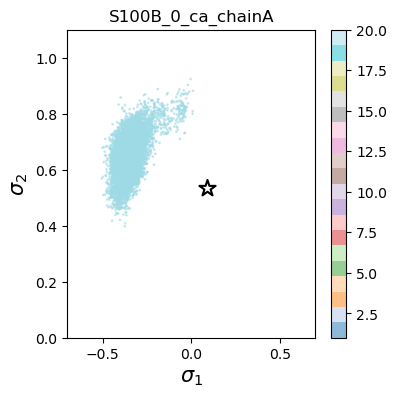

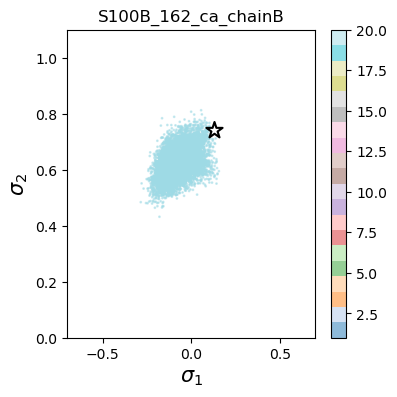

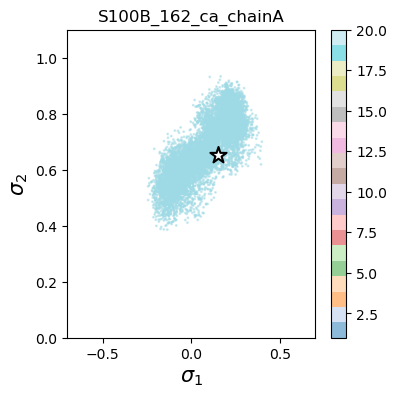

In [40]:
# Project initial structures of MD trajs
prefix=f"{wkdir}/IB_S100B_2500"
tmp_c = ['white', 'red']

lag = 2500
dt = f"{int(lag*1e-2)} ns"
prot = 'S100B'

op_id = [int(x) for x in np.loadtxt(f"{wkdir}/G_spib_op_id.txt")]
op_max = np.load(f"{wkdir}/{prot}/{prot}_input/max_unb.npy")
op_min = np.load(f"{wkdir}/{prot}/{prot}_input/min_unb.npy")    
weights=np.load(f"{wkdir}/{prot}/dt-{lag}/SPIB/Unweighted_d=2_t={lag}_{hyper}z_mean_encoder_weight0.npy")

for sys in ['S100A1', 'S100B']:  
    file_path = f'{prefix}/{sys}_wham.sh'
    with open(file_path, 'r') as file:
        for line in file:
            lim_x = [float(line.split()[2]), float(line.split()[3])]
            lim_y = [float(line.split()[6]), float(line.split()[7])]   

    listindices = glob.glob(f"{wkdir}/{sys}/{sys}_input/CV*")
    ls = []

    for i in range(len(listindices)):
        cv = np.loadtxt(f"{wkdir}/{sys}/{sys}_input/CVs_{i}.txt")
        ls_array = np.dot((cv-op_min)/(op_max-op_min), weights.T)
        ls.append(ls_array)    

    input_index=[np.ones(ls[i].shape[0],dtype=int)+i for i in range(len(listindices))]

    f_nodt=open(f"{wkdir}/{sys}/{sys}_input/listindices.txt")
    lines=f_nodt.readlines()
    Ini_dist = []
    titles = []
    for word in lines[0].split('/home/xg23/scratch/S100_clean/rave/'):
        if word[:4] == 'S100':
            print(word.split('/')[0], word.split('/')[1][4])
            pdb = word.split('/')[0]
            chain = word.split('/')[1][4]
            traj = md.load(f'/home/xgu/Tiwary/S100_clean/ini_md/{pdb}.pdb')
            distA, distB = scv.anchor_pairDist(traj)
            if chain == 'A':
                Ini_dist.append(distA)
            else:
                Ini_dist.append(distB)
            titles.append(f'{pdb}_chain{chain}')
    Ini_dist = np.squeeze(Ini_dist)[:,op_id]
    Ini_IB = np.dot((Ini_dist-op_min)/(op_max-op_min), weights.T)


    for i in range(len(listindices)):
        md_array = ls[i]
        fig = plt.figure(figsize=(4,4))    
        plot=plt.scatter(md_array.T[0],md_array.T[1],c=input_index[i],s=1,alpha=0.5,cmap="tab20",vmin=1,vmax=20)
        plt.scatter(Ini_IB[i][0],Ini_IB[i][1],marker='*',linewidths=1.5,c='white',edgecolors='black',s=150)

        plt.title(f'{titles[i]}',y=1.0)
        plt.xlabel("$\sigma_1$",fontsize=15)
        plt.ylabel("$\sigma_2$",fontsize=15)
        plt.xlim(lim_x)
        plt.ylim(lim_y)
        plt.colorbar(plot)

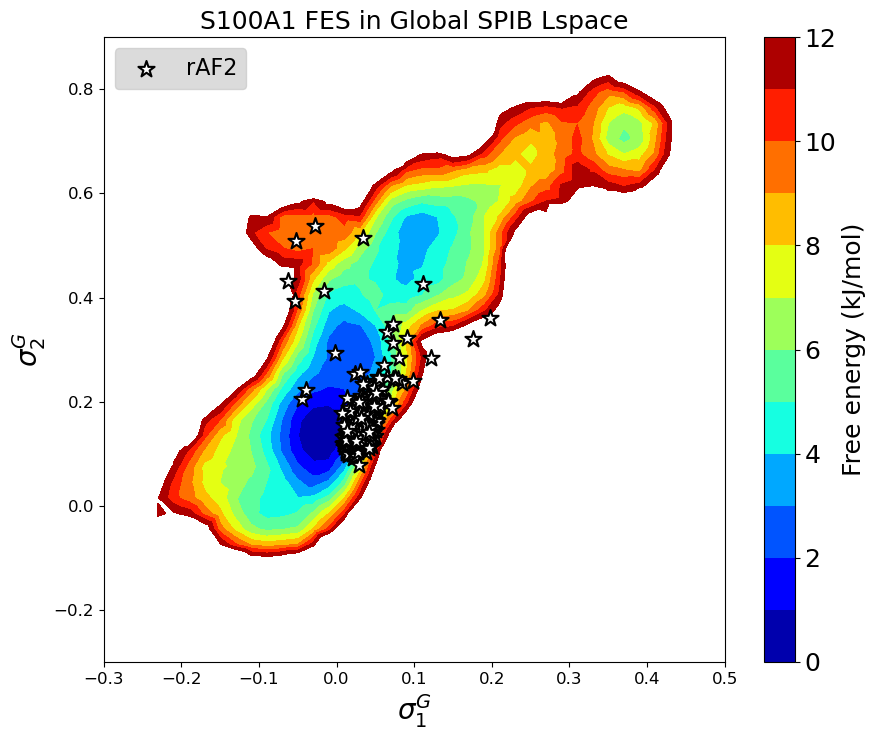

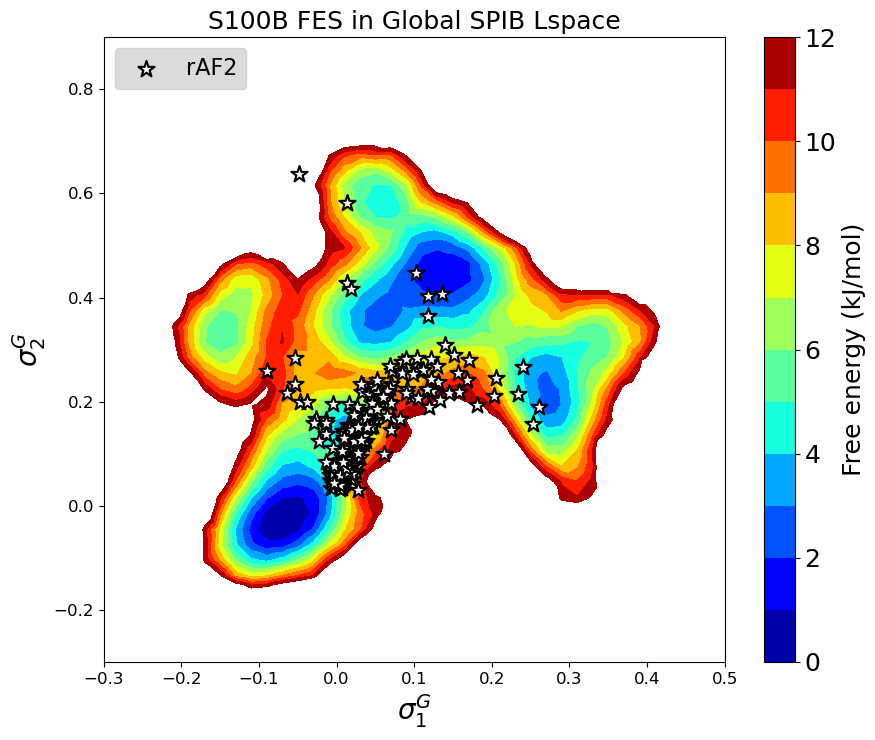

In [62]:
# Project rAF2
prefix=f"{wkdir}/IB_S100B_2500"
tmp_c = ['white', 'red']

lag = 2500
dt = f"{int(lag*1e-2)} ns"
prot = 'S100B'

op_id = [int(x) for x in np.loadtxt(f"{wkdir}/G_spib_op_id.txt")]
op_max = np.load(f"{wkdir}/{prot}/{prot}_input/max_unb.npy")
op_min = np.load(f"{wkdir}/{prot}/{prot}_input/min_unb.npy")    
weights=np.load(f"{wkdir}/{prot}/dt-{lag}/SPIB/Unweighted_d=2_t={lag}_{hyper}z_mean_encoder_weight0.npy")

for sys in ['S100A1', 'S100B']:  
    file_path = f'{prefix}/{sys}_wham.sh'
    with open(file_path, 'r') as file:
        for line in file:
            lim_x = [float(line.split()[2]), float(line.split()[3])]
            lim_y = [float(line.split()[6]), float(line.split()[7])]  
            
    a=pd.read_csv(f'{prefix}/{sys}_wham_pmf.txt', header=None, delim_whitespace=True, comment='#')
    a.columns = ['xx', 'yy', 'pmf','prob']
    b=a[a.pmf<9999]

    levels=np.arange(0, 13, 1)

    plt.figure(figsize=(9,7.5))
    ax = plt.gca()
    minp=np.min(b.pmf)
    CS = ax.tricontourf(b.xx, b.yy, b.pmf-minp, levels, cmap=plt.get_cmap('jet'))
    cbar = plt.colorbar(CS, ax=ax)
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label(label='Free energy (kJ/mol)',size=18)

    cv=np.loadtxt(f'/home/xgu/Tiwary/S100_clean/rAF2/t_anchorDist_{sys}.txt')[:,op_id]
    cv_norm = (cv-op_min)/(op_max-op_min)
    rAF2_IB = np.dot(cv_norm, weights.T)
    plt.scatter(rAF2_IB.T[0],rAF2_IB.T[1],marker='*',linewidths=1.5,c='white',edgecolors='black',s=150,label='rAF2') 
    

    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

    plt.title(f'{sys} FES in Global SPIB Lspace',y=1.0,fontsize=18)
    plt.xlabel("$\sigma_1^G$",fontsize=20)
    plt.ylabel("$\sigma_2^G$",fontsize=20)
    plt.xlim(lim_x)
    plt.ylim(lim_y)
    plt.legend(fontsize=16, loc='upper left',facecolor="lightgray")
    plt.tight_layout()
    plt.savefig(f"{wkdir}/{sys}_rAF2.png",dpi=300)   
    

In [75]:
# groups = sorted(groups, key=len, reverse=True)


In [84]:
# global basin filter for rAF2 ensemble
prefix=f"{wkdir}/IB_S100B_2500"
tmp_c = ['white', 'red']

lag = 2500
dt = f"{int(lag*1e-2)} ns"
prot = 'S100B'

op_id = [int(x) for x in np.loadtxt(f"{wkdir}/G_spib_op_id.txt")]
op_max = np.load(f"{wkdir}/{prot}/{prot}_input/max_unb.npy")
op_min = np.load(f"{wkdir}/{prot}/{prot}_input/min_unb.npy")    
weights=np.load(f"{wkdir}/{prot}/dt-{lag}/SPIB/Unweighted_d=2_t={lag}_{hyper}z_mean_encoder_weight0.npy")

# pmf_cutoffs=[3,3] # 3kJ/mol for S100A1, 3kJ/mol for S100B
pmf_cutoffs=[4,4] # 4kJ/mol for S100A1, 2kJ/mol for S100B

for isys, sys in enumerate(['S100A1', 'S100B']): 
    b, groups, bins = find_basins_on_FES(f'{prefix}/{sys}_wham_pmf.txt', pmf_cutoff=pmf_cutoffs[isys])
    # cutoff = np.linalg.norm(bins)
    cutoff = np.min(bins)

    a=pd.read_csv(f'{prefix}/{sys}_wham_pmf.txt', header=None, delim_whitespace=True, comment='#')
    a.columns = ['xx', 'yy', 'pmf','prob']
   
    cv=np.loadtxt(f'/home/xgu/Tiwary/S100_clean/rAF2/t_anchorDist_{sys}.txt')[:,op_id]
    cv_norm = (cv-op_min)/(op_max-op_min)
    rAF2_IB = np.dot(cv_norm, weights.T)
    
    #reindex groups by pmf values
    pmf_g = [np.min(b.iloc[list(g)].pmf.values) for g in groups]
    for ig, pmf_id in enumerate(np.argsort(pmf_g).tolist()[:2]):
        g = groups[pmf_id]
    # for ig, g in enumerate(groups[:2]):
        traj_id = []   
        array = np.transpose([np.array(b.iloc[list(g)].xx), np.array(b.iloc[list(g)].yy)])
        for i in range(len(rAF2_IB)):            
            check = rAF2_IB[i]
            dist = np.linalg.norm(array-check, axis=1)            
            if np.min(dist) < cutoff:
                traj_id.append(i)  
        traj_id = list(set(traj_id))
        # selected_frames = traj.slice(traj_id)
        # selected_frames.save_xtc(f'rAF2_Basin_{ig}_{sys}.xtc')
        np.savetxt(f'{wkdir}/{sys}_rAF2_GBasin_{ig}.id', traj_id, fmt='%d')
        print(len(traj_id), sys, ig)


462 S100A1 0
0 S100A1 1
76 S100B 0
4 S100B 1


/tmp/ipykernel_3955/3161390334.py:42: UserWarning: loadtxt: input contained no data: "/home/xgu/Tiwary/S100_clean/spib_G_tica//S100A1_rAF2_GBasin_1.id"
  traj_id= [int(i) for i in np.loadtxt(f'{wkdir}/{sys}_rAF2_GBasin_{ig}.id')]


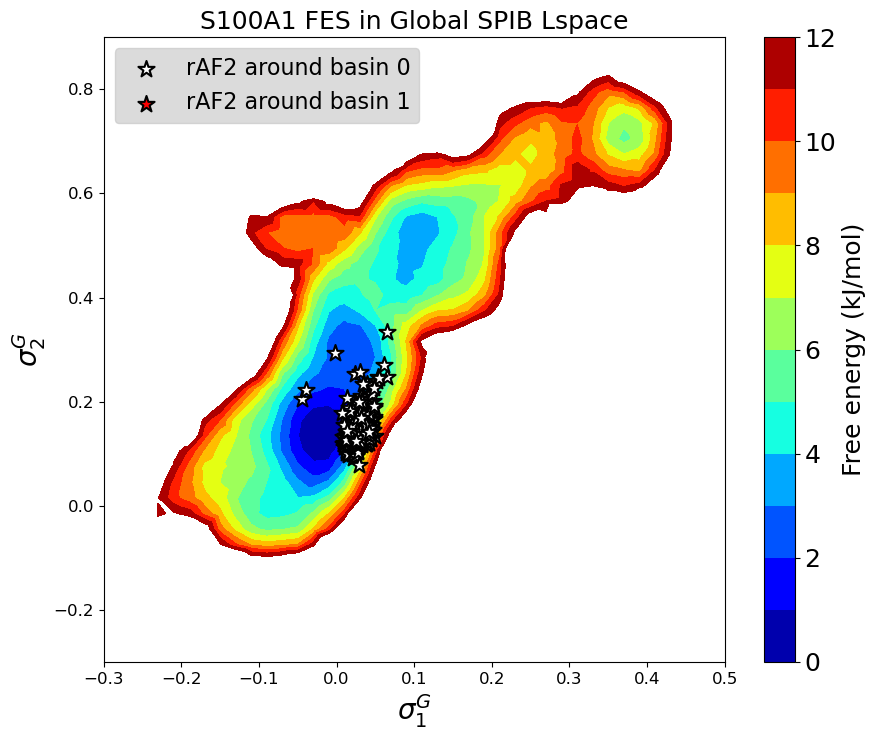

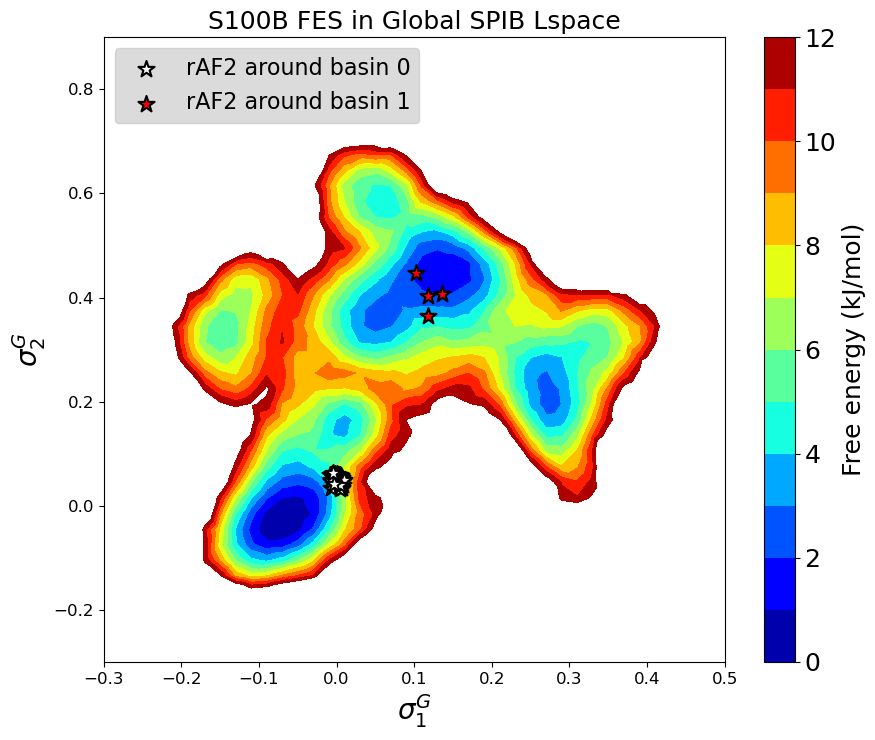

In [85]:
prefix=f"{wkdir}/IB_S100B_2500"
tmp_c = ['white', 'red']

lag = 2500
dt = f"{int(lag*1e-2)} ns"
prot = 'S100B'
tmp_c = ['white', 'red']
op_id = [int(x) for x in np.loadtxt(f"{wkdir}/G_spib_op_id.txt")]
op_max = np.load(f"{wkdir}/{prot}/{prot}_input/max_unb.npy")
op_min = np.load(f"{wkdir}/{prot}/{prot}_input/min_unb.npy")    
weights=np.load(f"{wkdir}/{prot}/dt-{lag}/SPIB/Unweighted_d=2_t={lag}_{hyper}z_mean_encoder_weight0.npy")

for sys in ['S100A1', 'S100B']:  
    file_path = f'{prefix}/{sys}_wham.sh'
    with open(file_path, 'r') as file:
        for line in file:
            lim_x = [float(line.split()[2]), float(line.split()[3])]
            lim_y = [float(line.split()[6]), float(line.split()[7])]  
    plt.figure(figsize=(9,7.5))    
    a=pd.read_csv(f'{prefix}/{sys}_wham_pmf.txt', header=None, delim_whitespace=True, comment='#')
    a.columns = ['xx', 'yy', 'pmf','prob']
    b=a[a.pmf<9999]
    levels=np.arange(0, 13, 1)    
    ax = plt.gca()
    minp=np.min(b.pmf)
    CS = ax.tricontourf(b.xx, b.yy, b.pmf-minp, levels, cmap=plt.get_cmap('jet'))
    cbar = plt.colorbar(CS, ax=ax)
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label(label='Free energy (kJ/mol)',size=18)  
    
    b, groups, bins = find_basins_on_FES(f'{prefix}/{sys}_wham_pmf.txt', pmf_cutoff=pmf_cutoffs[isys])
    cutoff = np.linalg.norm(bins)

    a=pd.read_csv(f'{prefix}/{sys}_wham_pmf.txt', header=None, delim_whitespace=True, comment='#')
    a.columns = ['xx', 'yy', 'pmf','prob']
   
    cv=np.loadtxt(f'/home/xgu/Tiwary/S100_clean/rAF2/t_anchorDist_{sys}.txt')[:,op_id]
    cv_norm = (cv-op_min)/(op_max-op_min)
    rAF2_IB = np.dot(cv_norm, weights.T)

    for ig in range(2):
        traj_id= [int(i) for i in np.loadtxt(f'{wkdir}/{sys}_rAF2_GBasin_{ig}.id')]
        plt.scatter(rAF2_IB.T[0][traj_id], rAF2_IB.T[1][traj_id], marker='*',linewidths=1.5,c=tmp_c[ig],edgecolors='black',s=150,label=f'rAF2 around basin {ig}') 
        

    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

    plt.title(f'{sys} FES in Global SPIB Lspace',y=1.0,fontsize=18)
    plt.xlabel("$\sigma_1^G$",fontsize=20)
    plt.ylabel("$\sigma_2^G$",fontsize=20)
    plt.xlim(lim_x)
    plt.ylim(lim_y)
    plt.legend(fontsize=16, loc='upper left',facecolor="lightgray")
    plt.tight_layout()
    plt.savefig(f"{wkdir}/{sys}_rAF2_basin.png",dpi=300)   

/home/xgu/Tiwary/S100_clean/tAF2/temp_S100B_b0_0/anchorDist.txt [[-0.10934313 -0.08021591]
 [-0.06247764 -0.06510963]
 [-0.06672878 -0.05576283]
 [-0.13453219 -0.04521511]
 [-0.08757393 -0.00210741]
 [-0.07041219 -0.07300704]
 [-0.10048556 -0.08641903]
 [-0.13895787 -0.06504597]
 [-0.08281541  0.03345637]
 [-0.09970822  0.03204875]
 [-0.10575966  0.00259591]
 [-0.08378888 -0.0501043 ]
 [-0.08423    -0.0332296 ]
 [-0.09004089 -0.11005591]
 [-0.10929822  0.03647209]
 [-0.00179448  0.00427192]
 [-0.06291523 -0.03848055]
 [-0.0488398  -0.02476344]
 [-0.12980541 -0.03432715]
 [-0.04610003  0.14469344]]
/home/xgu/Tiwary/S100_clean/tAF2/temp_S100B_b0_1/anchorDist.txt [[-0.08115237 -0.05252616]
 [-0.07024136 -0.05837765]
 [-0.00672171 -0.0773494 ]
 [-0.1172911  -0.08888645]
 [ 0.04545721 -0.04288341]
 [-0.08815426 -0.00476872]
 [-0.08832056 -0.07752638]
 [-0.0362021   0.02604866]
 [-0.06334931 -0.05604578]
 [ 0.00544349 -0.05879234]
 [ 0.02009344  0.07615246]
 [-0.0460558  -0.08422874]
 [-0.07

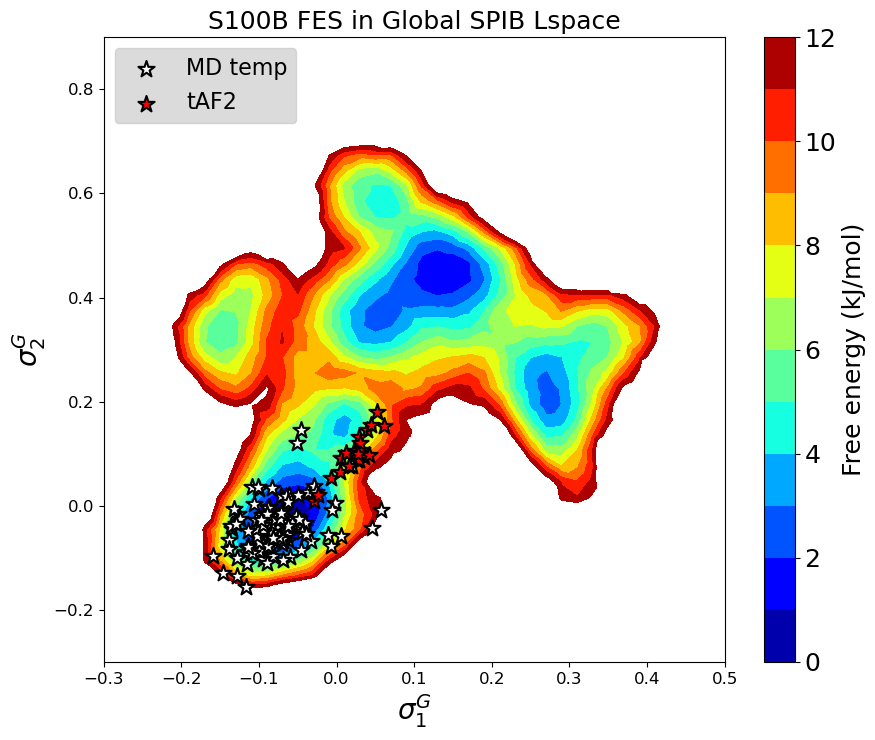

In [95]:
cmap = matplotlib.colormaps['tab10']
lag = 2500
dt = f"{int(lag*1e-2)} ns"
prot = 'S100B'

op_id = [int(x) for x in np.loadtxt(f"{wkdir}/G_spib_op_id.txt")]
op_max = np.load(f"{wkdir}/{prot}/{prot}_input/max_unb.npy")
op_min = np.load(f"{wkdir}/{prot}/{prot}_input/min_unb.npy")    
weights=np.load(f"{wkdir}/{prot}/dt-{lag}/SPIB/Unweighted_d=2_t={lag}_{hyper}z_mean_encoder_weight0.npy")

prefix=f"{wkdir}/IB_S100B_2500"
for sys in ['S100B']:  
    file_path = f'{prefix}/{sys}_wham.sh'
    with open(file_path, 'r') as file:
        for line in file:
            lim_x = [float(line.split()[2]), float(line.split()[3])]
            lim_y = [float(line.split()[6]), float(line.split()[7])]  

    a=pd.read_csv(f'{prefix}/{sys}_wham_pmf.txt', header=None, delim_whitespace=True, comment='#')

    a.columns = ['xx', 'yy', 'pmf','prob']
    b=a[a.pmf<9999]

    levels=np.arange(0, 13, 1)

    plt.figure(figsize=(9,7.5))
    ax = plt.gca()
    minp=np.min(b.pmf)
    CS = ax.tricontourf(b.xx, b.yy, b.pmf-minp, levels, cmap=plt.get_cmap('jet'))
    cbar = plt.colorbar(CS, ax=ax)
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label(label='Free energy (kJ/mol)',size=18)   
    
    # MD temp 
    files = glob.glob(f"/home/xgu/Tiwary/S100_clean/tAF2/temp_{sys}_*/anchorDist.txt")
    IBs = []
    for lid, pdb_file in enumerate(files):        
        cv = np.loadtxt(pdb_file)[:,op_id]
        cv_norm = (cv-op_min)/(op_max-op_min)
        IB = np.dot(cv_norm, weights.T)
        IBs.append(IB)
        print(pdb_file, IB)
    IBs = np.array(IBs)    
    plt.scatter(IBs.T[0], IBs.T[1], marker='*',linewidths=1.5,c='white',edgecolors='black',s=150,label='MD temp') 
    
   
    # tAF2
    files = glob.glob(f"/home/xgu/Tiwary/S100_clean/tAF2/{sys}_*/anchorDist.txt")
    IBs = []
    for lid, pdb_file in enumerate(files):        
        cv = np.loadtxt(pdb_file)[:,op_id]
        cv_norm = (cv-op_min)/(op_max-op_min)
        IB = np.dot(cv_norm, weights.T)
        IBs.append(IB)
        print(pdb_file, IB)
    IBs = np.array(IBs)    
    plt.scatter(IBs.T[0], IBs.T[1], marker='*',linewidths=1.5,c='red',edgecolors='black',s=150,label='tAF2') 
    
    
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

    plt.title(f'{sys} FES in Global SPIB Lspace',y=1.0,fontsize=18)
    plt.xlabel("$\sigma_1^G$",fontsize=20)
    plt.ylabel("$\sigma_2^G$",fontsize=20)
    plt.xlim(lim_x)
    plt.ylim(lim_y)
    plt.legend(fontsize=16, loc='upper left',facecolor="lightgray")
    plt.tight_layout()
    plt.savefig(f"{wkdir}/{sys}_tAF2.png",dpi=300)   

*project xrd*

/home/xgu/Tiwary/S100/rave/Holo/S100B/source/mono/3CR4_0_anchorDist.txt [0.00358279 0.05801059]
/home/xgu/Tiwary/S100/rave/Holo/S100B/source/mono/3GK4_0_anchorDist.txt [0.0171103  0.02642364]
/home/xgu/Tiwary/S100/rave/Holo/S100B/source/mono/3HCM_0_anchorDist.txt [0.0152724  0.07236096]
/home/xgu/Tiwary/S100/rave/Holo/S100B/source/mono/3HCM_1_anchorDist.txt [0.02016399 0.06847986]
/home/xgu/Tiwary/S100/rave/Holo/S100B/source/mono/3IQQ_0_anchorDist.txt [0.01416534 0.02976681]
/home/xgu/Tiwary/S100/rave/Holo/S100B/source/mono/3LK0_0_anchorDist.txt [-0.01261701 -0.02009821]
/home/xgu/Tiwary/S100/rave/Holo/S100B/source/mono/3LK0_1_anchorDist.txt [-0.01677962 -0.02113364]
/home/xgu/Tiwary/S100/rave/Holo/S100B/source/mono/3LK0_2_anchorDist.txt [-0.00903691 -0.00977688]
/home/xgu/Tiwary/S100/rave/Holo/S100B/source/mono/3LK0_3_anchorDist.txt [-0.01908552 -0.02767342]
/home/xgu/Tiwary/S100/rave/Holo/S100B/source/mono/3LLE_0_anchorDist.txt [0.01283632 0.14662811]
/home/xgu/Tiwary/S100/rave/Holo/

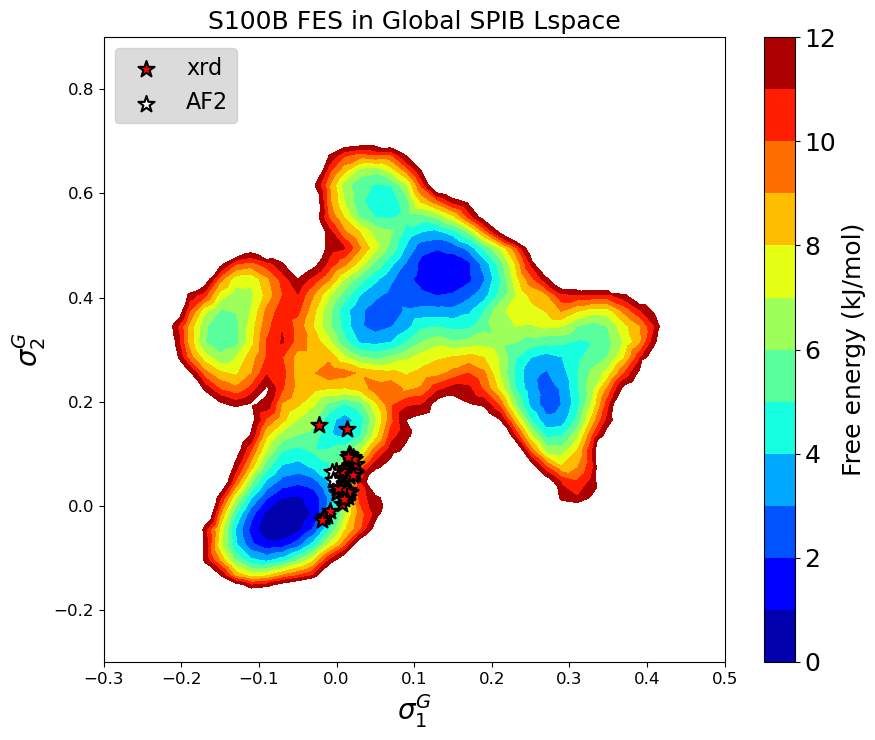

In [86]:
cmap = matplotlib.colormaps['tab10']
lag = 2500
dt = f"{int(lag*1e-2)} ns"
prot = 'S100B'

op_id = [int(x) for x in np.loadtxt(f"{wkdir}/G_spib_op_id.txt")]
op_max = np.load(f"{wkdir}/{prot}/{prot}_input/max_unb.npy")
op_min = np.load(f"{wkdir}/{prot}/{prot}_input/min_unb.npy")    
weights=np.load(f"{wkdir}/{prot}/dt-{lag}/SPIB/Unweighted_d=2_t={lag}_{hyper}z_mean_encoder_weight0.npy")

prefix=f"{wkdir}/IB_S100B_2500"
for sys in ['S100B']:  
    file_path = f'{prefix}/{sys}_wham.sh'
    with open(file_path, 'r') as file:
        for line in file:
            lim_x = [float(line.split()[2]), float(line.split()[3])]
            lim_y = [float(line.split()[6]), float(line.split()[7])]  

    a=pd.read_csv(f'{prefix}/{sys}_wham_pmf.txt', header=None, delim_whitespace=True, comment='#')

    a.columns = ['xx', 'yy', 'pmf','prob']
    b=a[a.pmf<9999]

    levels=np.arange(0, 13, 1)

    plt.figure(figsize=(9,7.5))
    ax = plt.gca()
    minp=np.min(b.pmf)
    CS = ax.tricontourf(b.xx, b.yy, b.pmf-minp, levels, cmap=plt.get_cmap('jet'))
    cbar = plt.colorbar(CS, ax=ax)
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label(label='Free energy (kJ/mol)',size=18)   
    
    # xrd
    files = glob.glob(f"/home/xgu/Tiwary/S100/rave/Holo/{sys}/source/mono/*anchorDist.txt")
    IBs = []
    for lid, pdb_file in enumerate(files):        
        cv = np.loadtxt(pdb_file)[op_id]
        cv_norm = (cv-op_min)/(op_max-op_min)
        IB = np.dot(cv_norm, weights.T)
        IBs.append(IB)
        print(pdb_file, IB)
    IBs = np.array(IBs)
    
    plt.scatter(IBs.T[0], IBs.T[1], marker='*',linewidths=1.5,c='red',edgecolors='black',s=150,label='xrd') 
    
    # AF2
    files = glob.glob(f"/home/xgu/Tiwary/S100/rave/Holo/{sys}/AF2*anchorDist.txt")
    IBs = []
    for lid, pdb_file in enumerate(files):        
        cv = np.loadtxt(pdb_file)[op_id]
        cv_norm = (cv-op_min)/(op_max-op_min)
        IB = np.dot(cv_norm, weights.T)
        IBs.append(IB)
        print(pdb_file, IB)
    IBs = np.array(IBs)    
    plt.scatter(IBs.T[0], IBs.T[1], marker='*',linewidths=1.5,c='white',edgecolors='black',s=150,label='AF2') 
    
    
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

    plt.title(f'{sys} FES in Global SPIB Lspace',y=1.0,fontsize=18)
    plt.xlabel("$\sigma_1^G$",fontsize=20)
    plt.ylabel("$\sigma_2^G$",fontsize=20)
    plt.xlim(lim_x)
    plt.ylim(lim_y)
    plt.legend(fontsize=16, loc='upper left',facecolor="lightgray")
    plt.tight_layout()
    plt.savefig(f"{wkdir}/{sys}_xrd.png",dpi=300)   

/home/xgu/Tiwary/S100/rave/Holo/S100A1/2K2F_anchorDist.txt [[0.13031888 0.23861216]
 [0.11705951 0.20075034]
 [0.07530036 0.23135147]
 [0.07358104 0.19762838]
 [0.08593233 0.21152702]
 [0.07023664 0.21014408]
 [0.10490135 0.23178393]
 [0.07163197 0.2035334 ]
 [0.08243093 0.18482091]
 [0.09100431 0.17341199]
 [0.08407622 0.20060746]
 [0.10601675 0.20770287]
 [0.10629474 0.18796412]
 [0.09148241 0.18122295]
 [0.11608887 0.23480289]
 [0.10072838 0.23924371]
 [0.1212061  0.21031833]
 [0.0922018  0.20834797]
 [0.11802348 0.2335049 ]
 [0.08533269 0.19452537]
 [0.13028943 0.23840122]
 [0.11716818 0.20137534]
 [0.07552215 0.23143427]
 [0.07344879 0.19778005]
 [0.08589049 0.21196403]
 [0.07034819 0.21098885]
 [0.10520791 0.23209132]
 [0.07182059 0.2034765 ]
 [0.08229129 0.18495752]
 [0.09074139 0.17362091]
 [0.08396352 0.20040994]
 [0.10601453 0.20776472]
 [0.10625007 0.18814732]
 [0.09152261 0.18159897]
 [0.1165822  0.23515762]
 [0.10040486 0.23912964]
 [0.120874   0.21049293]
 [0.09214598 0.2

/tmp/ipykernel_3955/1280122498.py:60: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(IB.T[0], IB.T[1], marker='*',linewidths=1.5,c=cmap(lid),edgecolors='black',s=150,label=f"{pdb_file.split('/')[-1].split('_')[0]}")


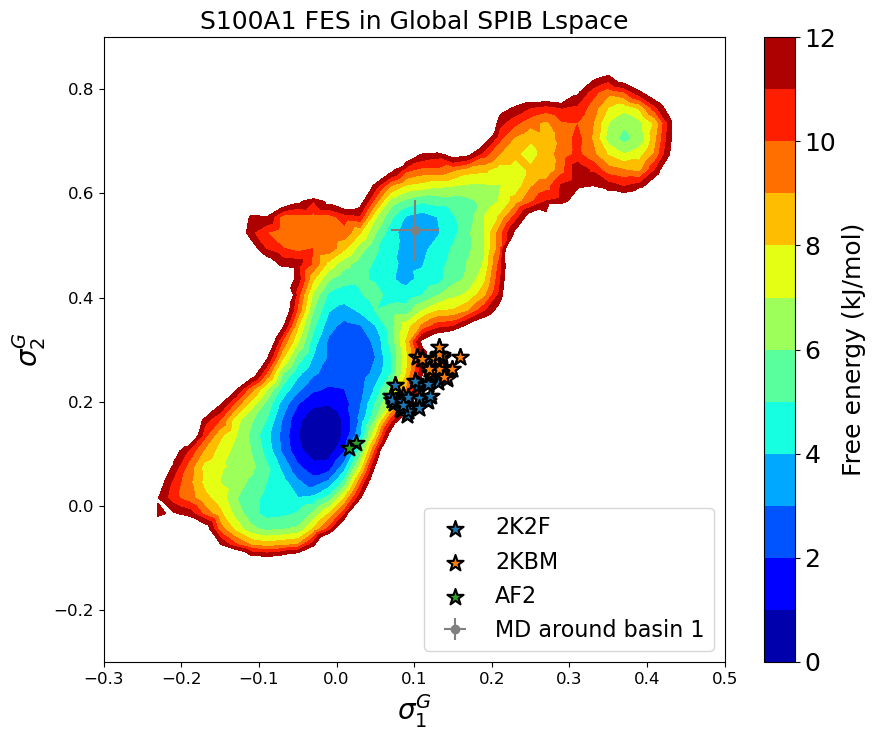

In [90]:
cmap = matplotlib.colormaps['tab10']
lag = 2500
dt = f"{int(lag*1e-2)} ns"
prot = 'S100B'

op_id = [int(x) for x in np.loadtxt(f"{wkdir}/G_spib_op_id.txt")]
op_max = np.load(f"{wkdir}/{prot}/{prot}_input/max_unb.npy")
op_min = np.load(f"{wkdir}/{prot}/{prot}_input/min_unb.npy")    
weights=np.load(f"{wkdir}/{prot}/dt-{lag}/SPIB/Unweighted_d=2_t={lag}_{hyper}z_mean_encoder_weight0.npy")

prefix=f"{wkdir}/IB_S100B_2500"
for sys in ['S100A1']:  
    file_path = f'{prefix}/{sys}_wham.sh'
    with open(file_path, 'r') as file:
        for line in file:
            lim_x = [float(line.split()[2]), float(line.split()[3])]
            lim_y = [float(line.split()[6]), float(line.split()[7])]  

    a=pd.read_csv(f'{prefix}/{sys}_wham_pmf.txt', header=None, delim_whitespace=True, comment='#')

    a.columns = ['xx', 'yy', 'pmf','prob']
    b=a[a.pmf<9999]

    levels=np.arange(0, 13, 1)

    plt.figure(figsize=(9,7.5))
    ax = plt.gca()
    minp=np.min(b.pmf)
    CS = ax.tricontourf(b.xx, b.yy, b.pmf-minp, levels, cmap=plt.get_cmap('jet'))
    cbar = plt.colorbar(CS, ax=ax)
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label(label='Free energy (kJ/mol)',size=18)  
    
    
    
    mean = []
    std = []
    cv_files = glob.glob(f"{wkdir}/{sys}/{sys}_input/CVs*txt")
    for fi in range(len(cv_files)):
        IBs = np.loadtxt(f'{prefix}/{sys}_{fi}.txt')[:,1:]
        mean.append(np.mean(IBs,axis=0))
        std.append(np.std(IBs,axis=0))
    mean = np.array(mean)
    std = np.array(std)  
    
    basin_traj = pd.read_csv(f'{wkdir}/basin_traj.csv')
    ig = 1
    df_tmp = basin_traj[(basin_traj.name.str.split('_').str[0]==sys) & (basin_traj.basin == ig)]
    traj_id = list(df_tmp.input_id)
    plt.errorbar(mean[traj_id,0], mean[traj_id,1], xerr=std[traj_id,0], yerr=std[traj_id,1], fmt='o', c='grey', label=f'MD around basin {ig}')
    
    
    
    nmr_files = glob.glob(f'/home/xgu/Tiwary/S100/rave/Holo/{sys}/*_anchorDist.txt')
    for lid, pdb_file in enumerate(nmr_files):        
        cv = np.loadtxt(pdb_file)[:,op_id]
        cv_norm = (cv-op_min)/(op_max-op_min)
        IB = np.dot(cv_norm, weights.T)
        print(pdb_file, IB)    
        plt.scatter(IB.T[0], IB.T[1], marker='*',linewidths=1.5,c=cmap(lid),edgecolors='black',s=150,label=f"{pdb_file.split('/')[-1].split('_')[0]}") 

    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

    plt.title(f'{sys} FES in Global SPIB Lspace',y=1.0,fontsize=18)
    plt.xlabel("$\sigma_1^G$",fontsize=20)
    plt.ylabel("$\sigma_2^G$",fontsize=20)
    plt.xlim(lim_x)
    plt.ylim(lim_y)
    plt.legend(fontsize=16, loc='lower right')
    plt.tight_layout()
    plt.savefig(f"{wkdir}/{sys}_xrd.png",dpi=300)   

/tmp/ipykernel_279/1758852484.py:59: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(IB.T[0], IB.T[1], marker='.',linewidths=1.5,c=cmap(lid),s=20,alpha=0.5,label=f"Apo-MD {pdb_file.split('/')[-2].split('_')[0]}_chain{pdb_file.split('/')[-1][4]}")


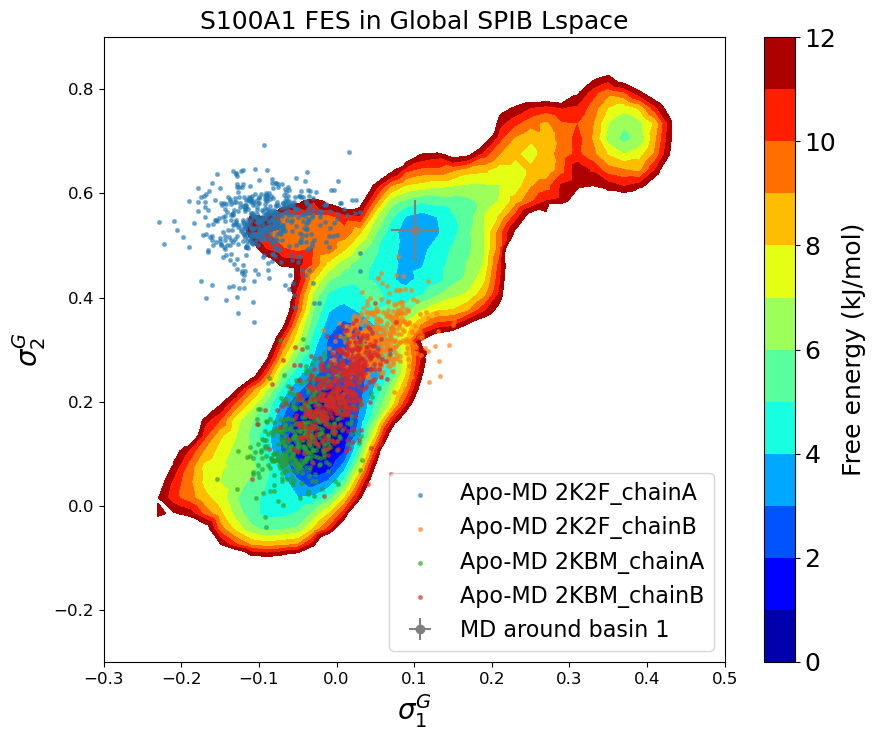

In [16]:
cmap = matplotlib.colormaps['tab10']
lag = 2500
dt = f"{int(lag*1e-2)} ns"
prot = 'S100B'

op_id = [int(x) for x in np.loadtxt(f"{wkdir}/G_spib_op_id.txt")]
op_max = np.load(f"{wkdir}/{prot}/{prot}_input/max_unb.npy")
op_min = np.load(f"{wkdir}/{prot}/{prot}_input/min_unb.npy")    
weights=np.load(f"{wkdir}/{prot}/dt-{lag}/SPIB/Unweighted_d=2_t={lag}_{hyper}z_mean_encoder_weight0.npy")

prefix=f"{wkdir}/IB_S100B_2500"
for sys in ['S100A1']:  
    file_path = f'{prefix}/{sys}_wham.sh'
    with open(file_path, 'r') as file:
        for line in file:
            lim_x = [float(line.split()[2]), float(line.split()[3])]
            lim_y = [float(line.split()[6]), float(line.split()[7])]  

    a=pd.read_csv(f'{prefix}/{sys}_wham_pmf.txt', header=None, delim_whitespace=True, comment='#')

    a.columns = ['xx', 'yy', 'pmf','prob']
    b=a[a.pmf<9999]

    levels=np.arange(0, 13, 1)

    plt.figure(figsize=(9,7.5))
    ax = plt.gca()
    minp=np.min(b.pmf)
    CS = ax.tricontourf(b.xx, b.yy, b.pmf-minp, levels, cmap=plt.get_cmap('jet'))
    cbar = plt.colorbar(CS, ax=ax)
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label(label='Free energy (kJ/mol)',size=18)  
    
    
    
    mean = []
    std = []
    cv_files = glob.glob(f"{wkdir}/{sys}/{sys}_input/CVs*txt")
    for fi in range(len(cv_files)):
        IBs = np.loadtxt(f'{prefix}/{sys}_{fi}.txt')[:,1:]
        mean.append(np.mean(IBs,axis=0))
        std.append(np.std(IBs,axis=0))
    mean = np.array(mean)
    std = np.array(std)  
    
    basin_traj = pd.read_csv(f'{wkdir}/basin_traj.csv')
    ig = 1
    df_tmp = basin_traj[(basin_traj.name.str.split('_').str[0]==sys) & (basin_traj.basin == ig)]
    traj_id = list(df_tmp.input_id)
    plt.errorbar(mean[traj_id,0], mean[traj_id,1], xerr=std[traj_id,0], yerr=std[traj_id,1], fmt='o', c='grey', label=f'MD around basin {ig}')
    
    
    
    nmr_files = glob.glob(f'/home/xgu/Tiwary/S100_clean/S100A_Peptide_remove/*_ca/Dist*')
    for lid, pdb_file in enumerate(nmr_files):        
        cv = np.loadtxt(f"{pdb_file}")[::20,op_id]
        cv_norm = (cv-op_min)/(op_max-op_min)
        IB = np.dot(cv_norm, weights.T)
        plt.scatter(IB.T[0], IB.T[1], marker='.',linewidths=1.5,c=cmap(lid),s=20,alpha=0.5,label=f"Apo-MD {pdb_file.split('/')[-2].split('_')[0]}_chain{pdb_file.split('/')[-1][4]}")

    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

    plt.title(f'{sys} FES in Global SPIB Lspace',y=1.0,fontsize=18)
    plt.xlabel("$\sigma_1^G$",fontsize=20)
    plt.ylabel("$\sigma_2^G$",fontsize=20)
    plt.xlim(lim_x)
    plt.ylim(lim_y)
    plt.legend(fontsize=16, loc='lower right')
    plt.tight_layout()
    plt.savefig(f"{wkdir}/{sys}_remove_pp.png",dpi=300) 